# Evaluation of image sythesis from PEMIU enhanced templates using ArcFace

- tbd

In [1]:
# System
import os

# Data preparation
import pandas as pd
import numpy as np
import math

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pysankey import sankey

import svgutils.compose as sc
from IPython.display import SVG

# Calculations: Normalization and cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

# Settings
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 8, 8
# sns.set_style('whitegrid')

In [2]:
# -----------------------------------------
# Path settings

# Graphics savepath
plt_savepath = "./final_eval_arcface_plt/"
os.makedirs(plt_savepath, exist_ok=True)

# Evaluation folder
evaluation_path = "../evaluation/"

# Experiment 7 folder (contains evaluation results with ArcFace)
experiment_7_path = "../recreate_icip2022_face_reconstruction/experiments/experiment_7_model1_pemiu_block_sizes/"

# Experiment 10 folder (contains ElasticFace)
experiment_10_path = "../recreate_icip2022_face_reconstruction/experiments/experiment_10_elastic/"

# Model training training_files (model trained with ArcFace)
training_files_path = "../recreate_icip2022_face_reconstruction/training_files/"

# Plot folder for biometric system eval
plot_bio_sys_eval_path = "./final_eval_ArcFace_biometric_system_plt/"
# -----------------------------------------

# Global variables
block_sizes = ["16", "32", "64", "128"]
face_extractor = "ArcFace"

In [3]:
# DataFrame imports

# Pyeer report unprotected for system evaluation
df_pyeer_unprotected = pd.read_csv(f"{evaluation_path}pyeer_lfwview2_pemiu16_biometric_performance/eer_report.csv", 
                       sep=",", skiprows=[0])
df_pyeer_unprotected.drop(df_pyeer_unprotected.index[1:], inplace=True)

# Mated / non-mated comparisons (LFW view2), normalized cos_sim calculations
df_genuine = pd.read_csv(f"{evaluation_path}lfwview2_genuine_cos_sim.csv", sep=",")
df_impostor = pd.read_csv(f"{evaluation_path}lfwview2_impostor_cos_sim.csv", sep=",")

# Model 1 training logs
df_model1_training = pd.read_csv(f"{training_files_path}logs_train/generator.csv", sep=",")
df_model1_training_training = pd.read_csv(f"{training_files_path}logs_train/log.txt", sep=",", header=None, names=['epoch', 'iteration','total_loss'])
df_model1_training_training['total_loss'] = df_model1_training_training['total_loss'].apply(lambda x: x.split(':')[-1])

# Visual evaluation
# Dataframe containing filepaths and cos_sim
df_reconstruction_cossim = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold1000/predicted_labels.csv', index_col=[0])
df_reconstruction_cossim_elasticface = pd.read_csv(f'{evaluation_path}/elasticface/attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/predicted_labels.csv', index_col=[0])

# Image quality
df_image_quality_arcface = pd.read_csv(f"{evaluation_path}image_quality/image_quality_reconstructed_pemiu.csv")

# Cos_sim PEMIU
df_cos_sim_pemiu = pd.read_csv(f"{experiment_7_path}cosine_similarity/cos_sim_samples_pemiu.csv", index_col='Unnamed: 0')
df_cos_sim_unprotected = pd.read_csv(f"{experiment_7_path}cosine_similarity/cos_sim_samples_unprotected.csv", index_col='Unnamed: 0')
df_cos_sim_unprotected_elastic = pd.read_csv(f"{experiment_10_path}cosine_similarity/cos_sim_samples_unprotected.csv", index_col='Unnamed: 0')

# Gender prediction ML analysis using k-fold cross validation
df_gender_pred_cv_from_img = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_with_cross_validation/attribute_from_img.csv', index_col=[0])
df_gender_pred_cv_from_embedding = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_with_cross_validation/attribute_from_embedding.csv', index_col=[0])

# Gender prediction: Equally distributed dataset
df_gender_pred_from_img = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/attribute_from_img.csv', index_col=[0])
df_gender_pred_from_embedding = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/attribute_from_embedding.csv', index_col=[0])
df_gender_pred_from_predicted_labels = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu/predicted_labels.csv', index_col=[0])

# Gender prediction TH100
df_gender_pred_th100_from_img = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold100/attribute_from_img.csv', index_col=[0])
df_gender_pred_th100_from_embedding = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold100/attribute_from_embedding.csv', index_col=[0])
df_gender_pred_th100_predicted_labels = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold100/predicted_labels.csv', index_col=[0])

# Gender prediction TH1000
df_gender_pred_th1000_from_img = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold1000/attribute_from_img.csv', index_col=[0])
df_gender_pred_th1000_predicted_labels = pd.read_csv(f'{evaluation_path}attribute_prediction_ml_attack_training_on_unprotected_prediction_on_pemiu_samples_that_pass_threshold1000/predicted_labels.csv', index_col=[0])

# LFW original gender labels
df_pairs_gender = pd.read_csv(f"{evaluation_path}lfw_complete_genders.csv", sep=",")

# InsightFace prediction
df_insightface_prediction = pd.read_csv(f"{evaluation_path}insightface_gender_prediction/insightface_gender_prediction.csv")

# InsightFace prediction at TH100 and TH1000
df_insightface_prediction_th100 = pd.read_csv(f"{evaluation_path}insightface_gender_prediction_img_that_pass_threshold100/insightface_gender_prediction_that_pass_th100.csv")
df_insightface_prediction_th1000 = pd.read_csv(f"{evaluation_path}insightface_gender_prediction_img_that_pass_threshold1000/insightface_gender_prediction_that_pass_th1000.csv")

In [4]:
# DataFrame modifications
df_cos_sim_all = pd.merge(df_cos_sim_unprotected, df_cos_sim_pemiu, on='filename', how='outer')

In [5]:
df_cos_sim_all.T

0                 1      \
filename                       Aaron_Eckhart_0001  Aaron_Guiel_0001   
cos_sim_reconstructed_vs_real            0.419634          0.271073   
cos_sim_pemiu16_vs_real                  -0.05259         -0.049463   
cos_sim_pemiu32_vs_real                  0.004599          0.069386   
cos_sim_pemiu64_vs_real                  0.136084           0.04484   
cos_sim_pemiu128_vs_real                 0.339503           0.18234   

                                              2                   3      \
filename                       Aaron_Patterson_0001  Aaron_Peirsol_0001   
cos_sim_reconstructed_vs_real              0.339001             0.33886   
cos_sim_pemiu16_vs_real                    0.138131           -0.038181   
cos_sim_pemiu32_vs_real                   -0.021905            0.025382   
cos_sim_pemiu64_vs_real                   -0.047909           -0.025505   
cos_sim_pemiu128_vs_real                   0.132808            0.059249   

                                            4                   5      \
filename                       Aaron_Peirsol_0002  Aaron_Peirsol_0003   
cos_sim_reconstructed_vs_real             0.44791            0.542268   
cos_sim_pemiu16_vs_real                 -0.022854           -0.031657   
cos_sim_pemiu32_vs_real                 -0.087568           -0.026239   
cos_sim_pemiu64_vs_real                 -0.048832            0.006904   
cos_sim_pemiu128_vs_real                 0.115987           -0.110291   

                                            6                7      \
filename                       Aaron_Peirsol_0004  Aaron_Pena_0001   
cos_sim_reconstructed_vs_real            0.389671         0.440148   
cos_sim_pemiu16_vs_real                 -0.020689         0.047002   
cos_sim_pemiu32_vs_real                 -0.066798         0.115017   
cos_sim_pemiu64_vs_real                  0.082643          0.23929   
cos_sim_pemiu128_vs_real                  0.07511         0.125456   

                                           8                  9      ...  \
filename                       Aaron_Sorkin_0001  Aaron_Sorkin_0002  ...   
cos_sim_reconstructed_vs_real           0.307352           0.452055  ...   
cos_sim_pemiu16_vs_real                 0.050479          -0.023529  ...   
cos_sim_pemiu32_vs_real                 0.099891           0.081902  ...   
cos_sim_pemiu64_vs_real                 0.090713           0.082379  ...   
cos_sim_pemiu128_vs_real                0.209507           0.000488  ...   

                                       13223                13224  \
filename                       Zoe_Ball_0001  Zoran_Djindjic_0001   
cos_sim_reconstructed_vs_real       0.582888             0.490273   
cos_sim_pemiu16_vs_real             0.042473             0.069887   
cos_sim_pemiu32_vs_real            -0.020302             0.050728   
cos_sim_pemiu64_vs_real             0.262991             0.114628   
cos_sim_pemiu128_vs_real             0.10952            -0.059488   

                                             13225                13226  \
filename                       Zoran_Djindjic_0002  Zoran_Djindjic_0003   
cos_sim_reconstructed_vs_real             0.443351             0.468363   
cos_sim_pemiu16_vs_real                  -0.061291              0.13025   
cos_sim_pemiu32_vs_real                   0.087727             0.176712   
cos_sim_pemiu64_vs_real                   0.121101            -0.001016   
cos_sim_pemiu128_vs_real                  0.275769             0.027838   

                                             13227                13228  \
filename                       Zoran_Djindjic_0004  Zorica_Radovic_0001   
cos_sim_reconstructed_vs_real             0.408235             0.622873   
cos_sim_pemiu16_vs_real                  -0.061415             0.027086   
cos_sim_pemiu32_vs_real                   0.082576             0.137468   
cos_sim_pemiu64_vs_real                     0.0576             0.166098   
cos_sim_pemiu128_vs_real

In [6]:
# Helper methods

def one_sample_per_subject(dataframe, evaluation_criteria: str):
    """
    Return a dataframe of LFW image set with only one sample per subject.
    If a subject has more than one sample, it is compared to the other choices by the provided evaluation criterion.

    Args:
        dataframe ():
        evaluation_criteria (): Dataframe column name. Valid choices, e.g.:
                                - img_original_quality

    Returns: pd.DataFrame
    """
    # Dataset should only include one sample per subject
    # Create a dict with name of subject as key and an empty list as value
    subjects = dataframe['filename'].apply(lambda x: x.split('_')[:-1]).tolist()
    subjects = ['_'.join(x) for x in subjects]
    indices = [[] for _ in range(len(subjects))]
    subjects_dict = dict(zip(subjects, indices))
    # Store row indices for each subject as values
    for index, row in dataframe.iterrows():
        if '_'.join(row['filename'].split('_')[:-1]) in subjects_dict:
            subjects_dict['_'.join(row['filename'].split('_')[:-1])].append(index)
    # Iterate over dict, remove all values except one for each key
    for key, value in subjects_dict.items():
        if len(value) > 1:
            # We keep the sample with the greatest value considering the evaluation criteria
            # Get all rows for indices of this subject as series.
            data = dataframe.iloc[subjects_dict[key]]
            # Get the index of the sample with the greatest value considering the criteria
            # Reduce the values to the chosen sample.
            subjects_dict[key] = [data[evaluation_criteria].idxmax()]
    # Iterate over dataframe.
    # Remove all rows which are not in the dictionary containing only unique subjects and samples
    for index, row in dataframe.iterrows():
        if [index] not in subjects_dict.values():
            dataframe.drop(index, inplace=True)

    return dataframe

In [9]:
# Load and modify dataframes
df = pd.read_csv("../evaluation/lfw_complete_genders_with_quality.csv", sep=",")
df = df[['lfw_image', 'img_original_quality', 'lfw_embedding', 'lfw_filename_raw', 'gender_official']]

# Add filename, remove file extension
df['filename'] = df['lfw_filename_raw'].apply(lambda x: x.split('.')[0])
df.drop(columns='lfw_filename_raw', inplace=True)

df.rename(columns={'lfw_embedding': 'embedding_original_arcface'}, inplace=True)
df.rename(columns={'lfw_image': 'img_original'}, inplace=True)

df['embedding_original_elasticface'] = df['filename'].apply(lambda x: f"../data/lfw_align_embeddings_elastic/{x}.npy")

df = df.merge(df_cos_sim_all, left_on="filename", right_on="filename")

# Only include one sample per identity: the one with the highest image quality.
df = one_sample_per_subject(df, "img_original_quality")

# Balance dataset to include a 50/50 amount of male and female samples
num_female = len(df[df["gender_official"] == "F"])
# Get indices of rows with male gender
male_indices = df[df['gender_official'] == "M"].index
# Reduce amount of male indices so that the total matches the number of female samples
male_indices = male_indices[num_female:]
# Drop superfluous indices
df = df.drop(male_indices)

# Samples have missing genders. Drop them.
df = df.drop(df[df['gender_official'] == "X"].index)

# Reset df index
df.reset_index(drop=True, inplace=True)

df_cos_sim_all_reduced = df

df_cos_sim_all_reduced

img_original  img_original_quality  \
0     ../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...              0.785188   
1     ../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...              0.764814   
2     ../data/lfw_align/Aaron_Patterson/Aaron_Patter...              0.737193   
3     ../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...              0.810206   
4      ../data/lfw_align/Aaron_Pena/Aaron_Pena_0001.png              0.829048   
...                                                 ...                   ...   
2937  ../data/lfw_align/Zelma_Novelo/Zelma_Novelo_00...              0.834612   
2938   ../data/lfw_align/Zhang_Ziyi/Zhang_Ziyi_0003.png              0.696282   
2939       ../data/lfw_align/Zoe_Ball/Zoe_Ball_0001.png              0.779261   
2940  ../data/lfw_align/Zorica_Radovic/Zorica_Radovi...              0.741519   
2941  ../data/lfw_align/Zumrati_Juma/Zumrati_Juma_00...              0.470757   

                             embedding_original_arcface gender_official  \
0       ../data/features_cleaner/Aaron_Eckhart_0001.npy               M   
1         ../data/features_cleaner/Aaron_Guiel_0001.npy               M   
2     ../data/features_cleaner/Aaron_Patterson_0001.npy               M   
3       ../data/features_cleaner/Aaron_Peirsol_0004.npy               M   
4          ../data/features_cleaner/Aaron_Pena_0001.npy               M   
...                                                 ...             ...   
2937     ../data/features_cleaner/Zelma_Novelo_0001.npy               F   
2938       ../data/features_cleaner/Zhang_Ziyi_0003.npy               F   
2939         ../data/features_cleaner/Zoe_Ball_0001.npy               F   
2940   ../data/features_cleaner/Zorica_Radovic_0001.npy               F   
2941     ../data/features_cleaner/Zumrati_Juma_0001.npy               F   

                  filename                     embedding_original_elasticface  \
0       Aaron_Eckhart_0001  ../data/lfw_align_embeddings_elastic/Aaron_Eck...   
1         Aaron_Guiel_0001  ../data/lfw_align_embeddings_elastic/Aaron_Gui...   
2     Aaron_Patterson_0001  ../data/lfw_align_embeddings_elastic/Aaron_Pat...   
3       Aaron_Peirsol_0004  ../data/lfw_align_embeddings_elastic/Aaron_Pei...   
4          Aaron_Pena_0001  ../data/lfw_align_embeddings_elastic/Aaron_Pen...   
...                    ...                                                ...   
2937     Zelma_Novelo_0001  ../data/lfw_align_embeddings_elastic/Zelma_Nov...   
2938       Zhang_Ziyi_0003  ../data/lfw_align_embeddings_elastic/Zhang_Ziy...   
2939         Zoe_Ball_0001  ../data/lfw_align_embeddings_elastic/Zoe_Ball_...   
2940   Zorica_Radovic_0001  ../data/lfw_align_embeddings_elastic/Zorica_Ra...   
2941     Zumrati_Juma_0001  ../data/lfw_align_embeddings_elastic/Zumrati_J...   

      cos_sim_reconstructed_vs_real  cos_sim_pemiu16_vs_real  \
0                          0.419634                -0.052590   
1                          0.271073                -0.049463   
2                          0.339001                 0.138131   
3                          0.389671                -0.020689   
4                          0.440148                 0.047002   
...                             ...                      ...   
2937                       0.615374                 0.168613   
2938                       0.266687                 0.081693   
2939                       0.582888                 0.042473   
2940                       0.622873                 0.027086   
2941                       0.382784                 0.082374   

      cos_sim_pemiu32_vs_real  cos_sim_pemiu64_vs_real  \
0                    0.004599                 0.136084   
1                    0.069386                 0.044840   
2                   -0.021905                -0.047909   
3                   -0.066798                 0.082643   
4                    0.115017                 0.239290   
...                       ...                      ...   
2937                 

---

## 1. Evaluation of biometric system performance


### Pyeer report

- LFW View 2 protocol

In [6]:
df_pyeer_unprotected.T

0
Experiment ID           Unprotected
GMean                      0.716181
GSTD                       0.102242
IMean                      0.002586
ISTD                       0.071711
Sensitivity index (d')     8.080924
AUC                         0.99924
J-Index                    0.995667
J-Index_TH                 0.289894
MCC                        0.995676
MCC_TH                     0.330774
EERlow                        0.003
EERhigh                       0.003
EER                           0.003
ZeroFMR                    0.004333
FMR1000                       0.004
FMR100                     0.002667
FMR20                         0.002
FMR10                      0.001667
ZeroFNMR                   0.537333
EER_TH                     0.206435
ZeroFMR_TH                 0.330774
FMR1000_TH                 0.247557
FMR100_TH                  0.170457
FMR20_TH                   0.124003
FMR10_TH                   0.095468
ZeroFNMR_TH               -0.005061

### Mated and non-mated cosine similarity including system thresholds

- Evaluation of bona fide biometric system performance

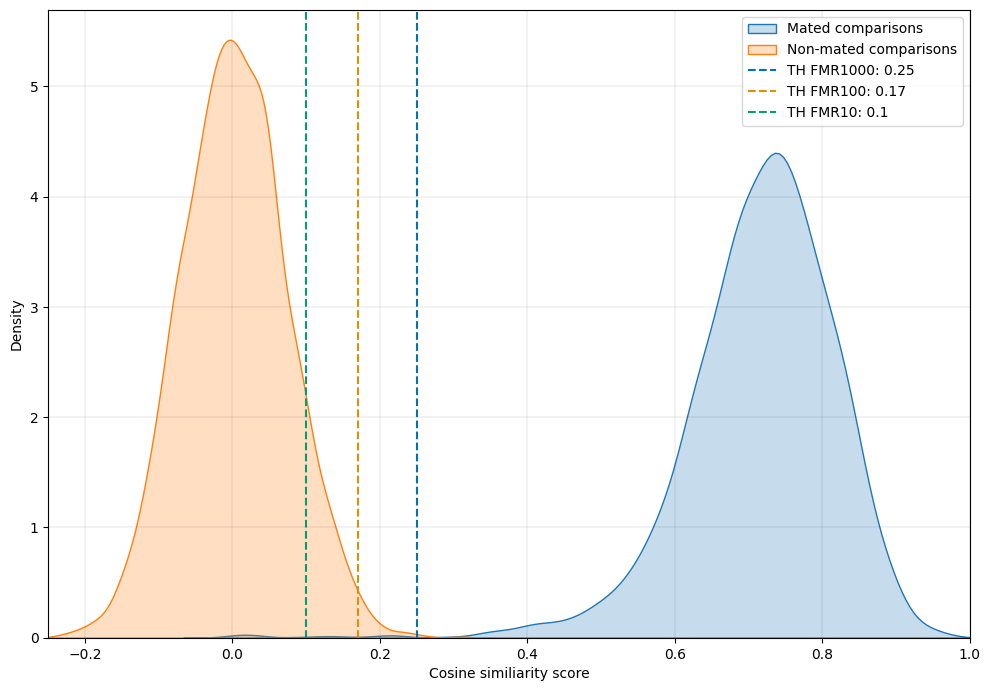

In [7]:
fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# Settings
labels_th = ['TH FMR1000', 'TH FMR100', 'TH FMR10']
colors = ["b", "r", "g", "c"]

# Title
# ax.set_title(f"Cosine similarity of LFW View2 comparison pairs and system thresholds using {face_extractor}")
#ax.set_title(f"{face_extractor}")

# Comparison: Genuine and impostor
sns.kdeplot(df_genuine['cos_sim_a_b'], label="Mated comparisons", fill=True)
sns.kdeplot(df_impostor['cos_sim_a_b'], label="Non-mated comparisons", fill=True)

ax.legend()
plt.xlim([-0.25, 1])
plt.xlabel('Cosine similiarity score') # between image comparison pairs

# Thresholds
for index, row in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    ax.axvline(x = round(((df_pyeer_unprotected[row].values[0])), 2), 
               color = sns.color_palette("colorblind")[index], linestyle="--",
               label = f'{labels_th[index]}: {round(df_pyeer_unprotected[row].values[0], 2)}')
ax.legend()

ax.grid(visible=True, which='major', color='black', linewidth=0.075)
# Show plot
plt.savefig(f'{plt_savepath}01_01_system_threshold.svg', bbox_inches='tight')
plt.show()

## Evaluation of biometric system with PE-MIU

---

---

## 2. Image reconstruction attack

- Goal: Reconstruct facial images from unprotected embeddings
- Applying the implementation by Shahreza et al.

### Model training

- The model was trained on an FFHQ image set found on Kaggle: https://www.kaggle.com/datasets/arnaud58/flickrfaceshq-dataset-ffhq The description of the dataset states that the set includes 52,000 files, in fact it consists of 52,001 files. The original FFHQ dataset consists of 70,000 files (https://github.com/NVlabs/ffhq-dataset), but we were unable to download the files from the official source.
- The original samples were of 512x512 px resolution. The samples were cropped and aligned to a certain eye position by applyingmethods from Shahreza et al. implementation in order to have a matching eye position over all of the training files.
- The embeddings used for training the model were generated from the processed samples using ArcFace iResNet100.
- For training, a random selection of 90% of the dataset was used. The remaining 10% were used for testing.
- The training ran for around 17 hours on a nVidia GTX 3090 graphics card to produce 100 model generations.

### Training loss of model 1

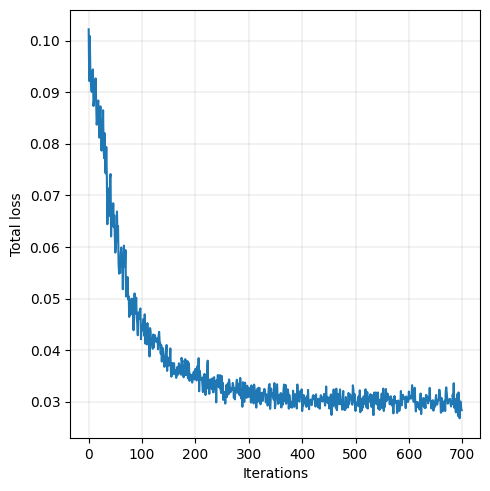

In [8]:
fig, ax = plt.subplots(1, 1,
                        figsize = (5, 5),
                        tight_layout = True)

# ax.set_title(f"Training loss of reconstruction model trained with {face_extractor}")
#ax.set_title(f"{face_extractor}")
ax = sns.lineplot(data=df_model1_training_training['total_loss'].apply(lambda x: float(x)))
ax.set(ylabel="Total loss", xlabel="Iterations")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
# Show plot
plt.savefig(f'{plt_savepath}02_01_training_loss_model1.svg', bbox_inches='tight')
plt.show()

# df_model1_training_training

### Testing loss of model 1

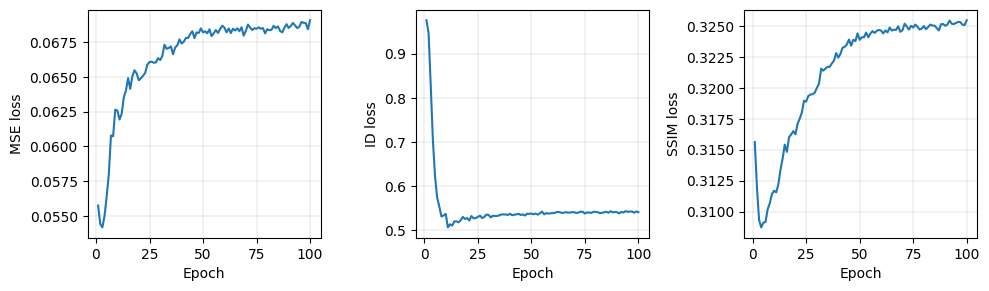

In [9]:
fig, ax = plt.subplots(1, 3,
                        figsize = (10, 3),
                        tight_layout = True)
# fig.suptitle(f"Testing loss of reconstruction model trained with {face_extractor}")
#fig.suptitle(f"{face_extractor}")
ax[0] = sns.lineplot(x=df_model1_training['epoch'], y=df_model1_training['MSE_loss_Gen'], ax=ax[0])
ax[1] = sns.lineplot(x=df_model1_training['epoch'], y=df_model1_training['ID_loss_Gen'], ax=ax[1])
ax[2] = sns.lineplot(x=df_model1_training['epoch'], y=df_model1_training['ssim_loss_Gen_test'], ax=ax[2])
ax[0].set(ylabel="MSE loss")
ax[1].set(ylabel="ID loss")
ax[2].set(ylabel="SSIM loss")
for a in ax:
    a.grid(visible=True, which='major', color='black', linewidth=0.075)
    a.set_xlabel('Epoch')

# Show plot
plt.savefig(f'{plt_savepath}02_02_testing_loss_model1.svg', bbox_inches='tight')
plt.show()

### Visual sample of model training

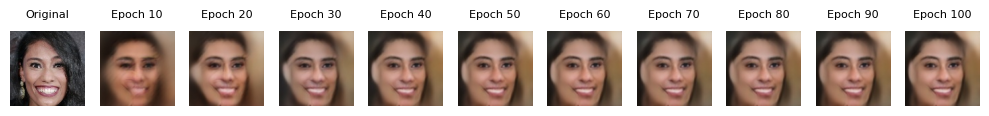

In [10]:
path = f"{training_files_path}Generated_images/14/"
img = []
img.append(mpimg.imread(f"{path}real_image_0.jpg"))
for i in range(10):
    img.append(mpimg.imread(f"{path}epoch_{(i+1)*10}.jpg"))
    
# display images
fig, ax = plt.subplots(1,11,
                       figsize = (10, 7),
                        tight_layout = True)
# fig.suptitle(f"{face_extractor}")
#fig.text(0.5, 0.62, f"{face_extractor}", ha='center', rotation=0)
ax[0].set_title("Original", pad=10, size=8)
for i in range(1, 11):
    ax[i].set_title(f"Epoch {i*10}", pad=10, size=8)

for x in range(len(ax)):
    ax[x].axis('off')
    ax[x].imshow(img[x])
    
plt.savefig(f'{plt_savepath}02_03_model_training_visual_sample.svg', bbox_inches='tight')
plt.show()

In [11]:
df_cos_sim_all.head()

filename  cos_sim_reconstructed_vs_real  \
0    Aaron_Eckhart_0001                       0.419634   
1      Aaron_Guiel_0001                       0.271073   
2  Aaron_Patterson_0001                       0.339001   
3    Aaron_Peirsol_0001                       0.338860   
4    Aaron_Peirsol_0002                       0.447910   

   cos_sim_pemiu16_vs_real  cos_sim_pemiu32_vs_real  cos_sim_pemiu64_vs_real  \
0                -0.052590                 0.004599                 0.136084   
1                -0.049463                 0.069386                 0.044840   
2                 0.138131                -0.021905                -0.047909   
3                -0.038181                 0.025382                -0.025505   
4                -0.022854                -0.087568                -0.048832   

   cos_sim_pemiu128_vs_real  
0                  0.339503  
1                  0.182340  
2                  0.132808  
3                  0.059249  
4                  0.115987

In [12]:
def get_original_image(filename):
    return f"../data/lfw_align/{'_'.join(filename.split('_')[:-1])}/{filename}.png"

def get_reconstructed_image(filename, fe:str):
    if fe == "ArcFace":
        path = f"{experiment_7_path}sample_images_unprotected"
        return f"{path}/{filename}_reconstructed.png"
    else:
        path = f"{experiment_10_path}sample_images_unprotected"
        return f"{path}/{filename}_model4_unprotected.png"

def get_pemiu_image(filename, blocksize, fe:str):
    if fe == "ArcFace":
        path = f"{experiment_7_path}sample_images_pemiu{blocksize}"
        return f"{path}/{filename}_pemiu{blocksize}.png"
    else:
        path = f"{experiment_10_path}sample_images_pemiu{blocksize}"
        return f"{path}/{filename}_model4_pemiu{blocksize}.png"

def get_cos_sim(filename, blocksize=False):
    if blocksize:
        return format(round(df_reconstruction_cossim[df_reconstruction_cossim['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_pemiu{blocksize}'].tolist()[0], 2), '.2f')
    else:
        return format(round(df_cos_sim_all[df_cos_sim_all['filename'] == f'{filename}'][f'cos_sim_reconstructed_vs_real'].tolist()[0], 2), '.2f')

def get_cos_sim_elasticface(filename, blocksize=False):
    if blocksize:
        return format(round(df_reconstruction_cossim_elasticface[df_reconstruction_cossim_elasticface['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_pemiu{blocksize}'].tolist()[0], 2), '.2f')
    else:
        return format(round(df_cos_sim_unprotected_elastic[df_cos_sim_unprotected_elastic['filename'] == f'{filename}'][f'cos_sim_reconstructed_vs_real'].tolist()[0], 2), '.2f')

def get_gender_prediction(filename, blocksize):
    return df_reconstruction_cossim[df_reconstruction_cossim['filename'] == f'{filename}'][f'pred_fromimg_{blocksize}_svm_poly'].tolist()[0]

def get_gender(filename):
    return df_reconstruction_cossim[df_reconstruction_cossim['filename'] == f'{filename}'][f'gender_official'].tolist()[0]
    
def display_image(filename, display_title=False):
    fig, ax = plt.subplots(1,3,
                           figsize = (6, 7),
                           tight_layout = True)
    if display_title:
        ax[0].set_title(f"Original", pad=10)
        ax[1].set_title("ArcFace", pad=10)
        ax[2].set_title("ElasticFace", pad=10)
    
    # Display cosine similarity score
    ax[0].text(4, 152, f"{filename}", fontsize=8, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[1].text(80, 105, get_cos_sim(filename), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[2].text(80, 105, get_cos_sim_elasticface(filename), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    
    ax[0].imshow(mpimg.imread(get_original_image(filename)))
    ax[1].imshow(mpimg.imread(get_reconstructed_image(filename, "ArcFace")))
    ax[2].imshow(mpimg.imread(get_reconstructed_image(filename, "ElasticFace")))
     
    for x in range(0, 3):
        ax[x].axis('off')

In [13]:
# Sort dataframe for greatest cos_sim of recontructed image
df_reconstruction_cossim.sort_values(by='cos_sim_bonafide_synthesized_unprotected_normalized', axis=0, ascending=False, inplace=True)

### Reconstruct images from unprotected embeddings

- Use the model to reconstruct images from LFW dataset
- Embeddings created using ArcFace IResNet 100
- Random sample of images with high cosine similarity
- Number displayed in reconstructed image is cosine similarity

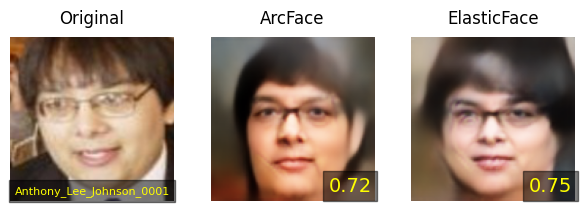

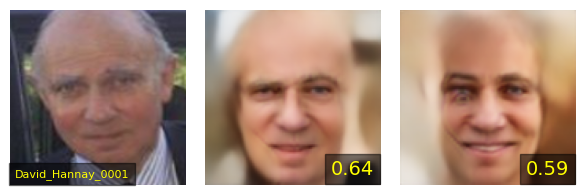

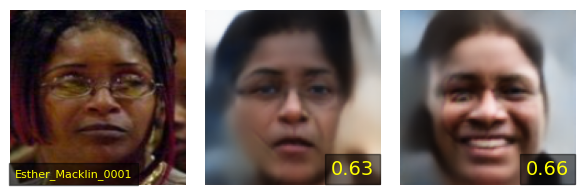

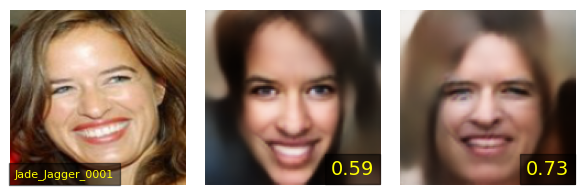

In [14]:
# Highest cos_sim for male subjects
for i, index in enumerate([11, 189, 246, 601]):
    if i == 0:
        display_image(df_reconstruction_cossim['filename'].iloc[index], display_title=True)
    else:
        display_image(df_reconstruction_cossim['filename'].iloc[index])
    plt.savefig(f'{plt_savepath}02_04_{i}_reconstruct_images.svg', bbox_inches='tight')

### Evaluation of attack performance

- LFW View 2 comparison paris
- SISFE (Same image same feature extractor), also called Type-I attack
    - Cosine similarity between original image and reconstructed image
    - Origin of the reconstructed image is the embedding of the original image
- DIFSE (Differnet image same feature extractor), also called Type-II attack
    - Cosine similarity between original image and recontructed image from the original image's embedding
    - Origin of the reconstructed image is an embedding from a different sample of the same subject

In [12]:
df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]

FMR1000_TH  FMR100_TH  FMR10_TH
0    0.247557   0.170457  0.095468

In [13]:
successful_attacks = []
for i, (row) in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    num = len(df_genuine[df_genuine['cos_sim_a_a_reconstructed'] > round(df_pyeer_unprotected[row].values[0], 3)])
    num = round((num / len(df_genuine) * 100), 2)
    successful_attacks.append(num)
successful_attacks

[100.0, 100.0, 100.0]

In [14]:
successful_attacks = []
for i, (row) in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    num = len(df_genuine[df_genuine['cos_sim_a_b_reconstructed'] > round(df_pyeer_unprotected[row].values[0], 3)])
    num = round((num / len(df_genuine) * 100), 2)
    successful_attacks.append(num)
successful_attacks

[94.3, 99.0, 99.63]

In [15]:
round(df_pyeer_unprotected['FMR1000_TH'].values[0], 3)

0.248

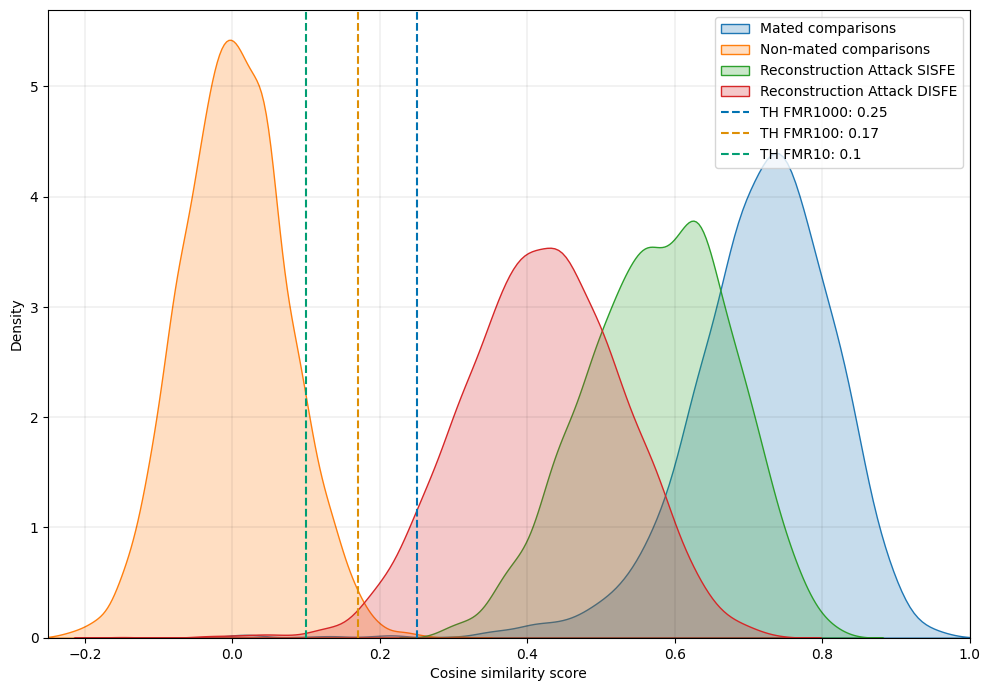

In [19]:
fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# Title
# fig.suptitle(f"Cosine similarity of LFW View2 comparison pairs using {face_extractor}:\n" \
#              "Mated/non-mated, reconstructed images (unprotected templates), system thresholds")
#fig.suptitle(f"{face_extractor}")
# Settings
labels_th = ['TH FMR1000', 'TH FMR100', 'TH FMR10']
colors = ["b", "r", "g", "c"]

sns.kdeplot(df_genuine['cos_sim_a_b'], ax=ax, label="Mated comparisons", fill=True)
sns.kdeplot(df_impostor['cos_sim_a_b'], label="Non-mated comparisons", fill=True)
sns.kdeplot(df_genuine['cos_sim_a_a_reconstructed'], label="Reconstruction Attack SISFE", fill=True)
sns.kdeplot(df_genuine['cos_sim_a_b_reconstructed'], label="Reconstruction Attack DISFE", fill=True)

ax.legend()
plt.xlim([-0.25, 1])
ax.set(xlabel="Cosine similarity score")  # between image compaison pairs

# Thresholds
for index, row in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    ax.axvline(x = round(((df_pyeer_unprotected[row].values[0])), 2), 
               color = sns.color_palette("colorblind")[index], linestyle="--", 
               label = f'{labels_th[index]}: {round(df_pyeer_unprotected[row].values[0], 2)}')
ax.legend()
ax.grid(visible=True, which='major', color='black', linewidth=0.075)

# Show plot
plt.savefig(f'{plt_savepath}02_05_attack_performance.svg', bbox_inches='tight')
plt.show()

### Image quality of original and reconstructed images
- SER-FIQ quality assessment

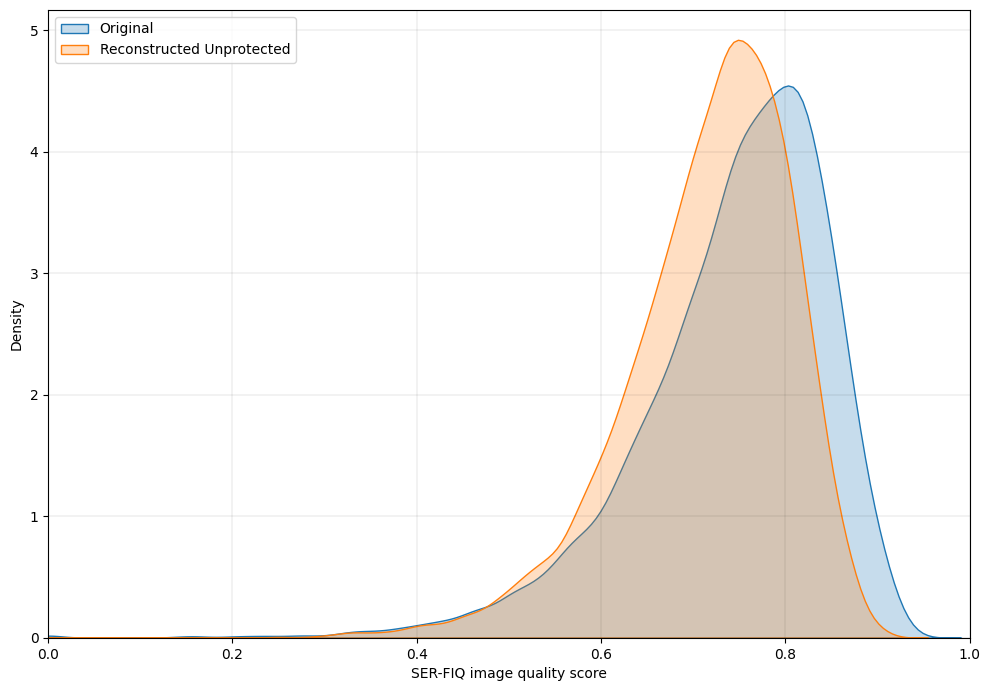

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7), tight_layout = True)
# Title
# fig.suptitle(f"Evaluation of image quality between original and reconstructed images using {face_extractor}")
#fig.suptitle(f"{face_extractor}")
# Settings
labels = ["Original", "Reconstructed Unprotected"]

sns.kdeplot(df_image_quality_arcface[f'quality_img_original'], ax=ax, label=labels[0], fill=True)
sns.kdeplot(df_image_quality_arcface[f'quality_img_reconstructed'], ax=ax, label=labels[1], fill=True)
ax.label_outer()
ax.legend(loc=2)
ax.set(xlabel="SER-FIQ image quality score")    
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
    
# Render plot
plt.xlim([0, 1])
plt.savefig(f'{plt_savepath}02_06_image_quality.svg', bbox_inches='tight')
plt.show()

---

## 3. Privacy-enhancement using PEMIU

- Enhance privacy of embeddings using PEMIU by Terhörst et al.
- Create PEMIU embeddings with varying block sizes: 16, 32, 64, 128

### Cosine similarity between images reconstructed from PEMIU enhanced templates and original images

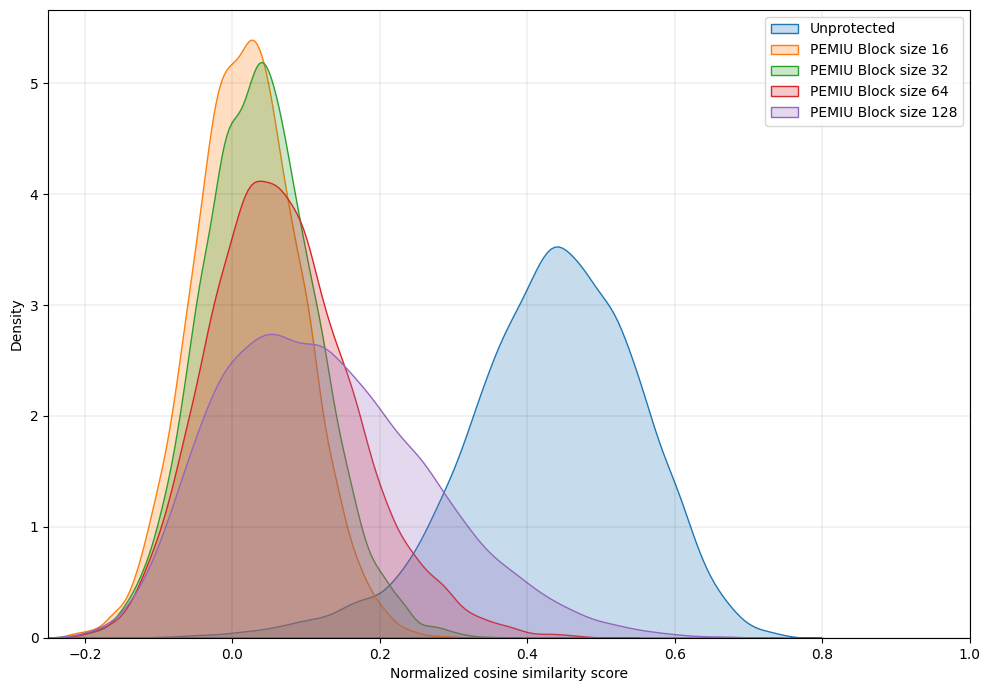

In [21]:
fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# todo: Add comment
sns.kdeplot(df_cos_sim_all[f'cos_sim_reconstructed_vs_real'], ax=ax, label=f"Unprotected", fill=True)
for blocksize in block_sizes:
    sns.kdeplot(df_cos_sim_all[f'cos_sim_pemiu{blocksize}_vs_real'], label=f"PEMIU Block size {blocksize}", fill=True)

ax.legend()
# ax.set_title(f"Cosine similarity between original images and reconstructed images:\n" \
#              f"Unprotected, PEMIU enhanced at varying block sizes using {face_extractor}")
#ax.set_title(f"{face_extractor}")
plt.xlim([-0.25, 1])
ax.set(xlabel="Normalized cosine similarity score")  # between comparison pairs
    
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
# Show plot
plt.savefig(f'{plt_savepath}03_01_cossim_original_reconstructed_pemiu.svg', bbox_inches='tight')
plt.show()

### SISFE attack performed with PEMIU enhanced images

- Compare cosine similarity between images reconstrcuted from unprotected embeddings with images reconstructed from PEMIU enhanced embeddings at varying block sizes
- Display biometric system acceptance thresholds
- Block size is the PEMIU shuffle block size parameter

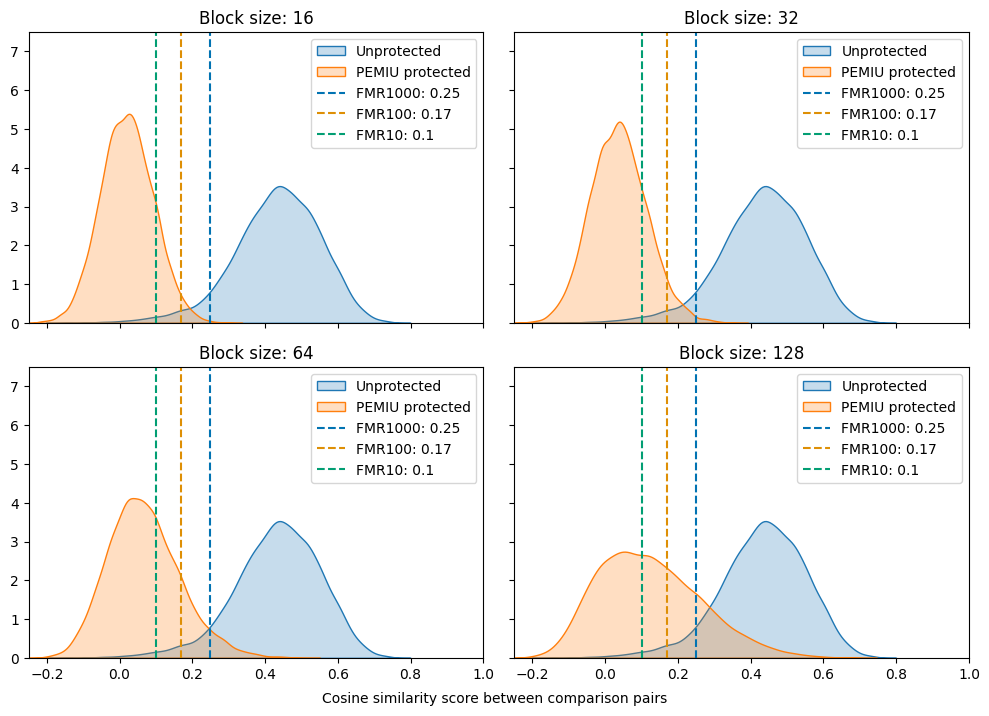

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,
                        figsize = (10, 7),
                        tight_layout = True)

# Title
# fig.suptitle(f"SISFE Attack: Reconstructed images from unprotected embeddings,\n" \
#              f"PEMIU enhanced embeddings at varying block sizes, system thresholds, using {face_extractor}")
#fig.suptitle(f"{face_extractor}")
# Settings
labels_th = ['FMR1000', 'FMR100', 'FMR10']
colors = ["b", "r", "g", "c"]

for i, (blocksize, ax) in enumerate(zip(block_sizes, fig.get_axes())):
    sns.kdeplot(df_cos_sim_all[f'cos_sim_reconstructed_vs_real'], ax=ax, label=f"Unprotected", fill=True)
    sns.kdeplot(df_cos_sim_all[f'cos_sim_pemiu{blocksize}_vs_real'], ax=ax, label=f"PEMIU protected", fill=True)
    ax.set_title(f"Block size: {blocksize}")
    ax.set_xlim(-0.25, 1)
    ax.set_ylim(0, 7.5)
    ax.label_outer()
    # Thresholds
    for index, row in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
        ax.axvline(x = round(((df_pyeer_unprotected[row].values[0])), 2), 
                   color = sns.color_palette("colorblind")[index], 
                   linestyle="--",
                   label = f'{labels_th[index]}: {round(df_pyeer_unprotected[row].values[0], 2)}')
    ax.legend()
    ax.set(xlabel="")
    ax.set(ylabel="")
    # .grid(visible=True, which='major', color='black', linewidth=0.075)

# plt.xlabel = "Normalized cosine similarity score between comparison pairs"
fig.text(0.5, -0.01, 'Cosine similarity score between comparison pairs', ha='center')
    
# Render plot
plt.xlim([-0.25, 1])
plt.savefig(f'{plt_savepath}03_02_sisfe_attack_pemiu_at_system_threshold.svg', bbox_inches='tight')
plt.show()

### Success attack rate using images reconstructed from PEMIU enhanced embeddings

In [21]:
successful_attacks = []
for i, (row) in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    for blocksize in block_sizes:
        num = len(df_cos_sim_all[df_cos_sim_all[f'cos_sim_pemiu{blocksize}_vs_real'] > round(df_pyeer_unprotected[row].values[0], 3)])
        num = round((num / len(df_cos_sim_all) * 100), 2)
        successful_attacks.append(num)
successful_attacks

[0.11, 0.6, 4.62, 19.22, 2.12, 4.66, 14.48, 34.65, 15.5, 22.26, 36.03, 53.89]

In [12]:
# Attack success rates with reduced and balacned dataset: vs. PEMIU protected templates

successful_attacks = []
for i, (row) in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    for blocksize in block_sizes:
        num = len(df_cos_sim_all_reduced[df_cos_sim_all_reduced[f'cos_sim_pemiu{blocksize}_vs_real'] > round(df_pyeer_unprotected[row].values[0], 3)])
        num = round((num / len(df_cos_sim_all_reduced) * 100), 2)
        successful_attacks.append(num)
successful_attacks

[0.14, 0.82, 5.74, 21.18, 2.38, 6.12, 17.98, 36.78, 15.67, 24.47, 39.97, 56.25]

In [14]:
# Attack success rates with reduced and balacned dataset: vs. Unmodified templates

successful_attacks = []
for i, (row) in enumerate(df_pyeer_unprotected[['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
    num = len(df_cos_sim_all_reduced[df_cos_sim_all_reduced[f'cos_sim_reconstructed_vs_real'] > round(df_pyeer_unprotected[row].values[0], 3)])
    num = round((num / len(df_cos_sim_all_reduced) * 100), 2)
    successful_attacks.append(num)
successful_attacks

[95.04, 97.52, 99.01]

In [13]:
df_cos_sim_all_reduced.columns

Index(['img_original', 'img_original_quality', 'embedding_original_arcface',
       'gender_official', 'filename', 'embedding_original_elasticface',
       'cos_sim_reconstructed_vs_real', 'cos_sim_pemiu16_vs_real',
       'cos_sim_pemiu32_vs_real', 'cos_sim_pemiu64_vs_real',
       'cos_sim_pemiu128_vs_real'],
      dtype='object')

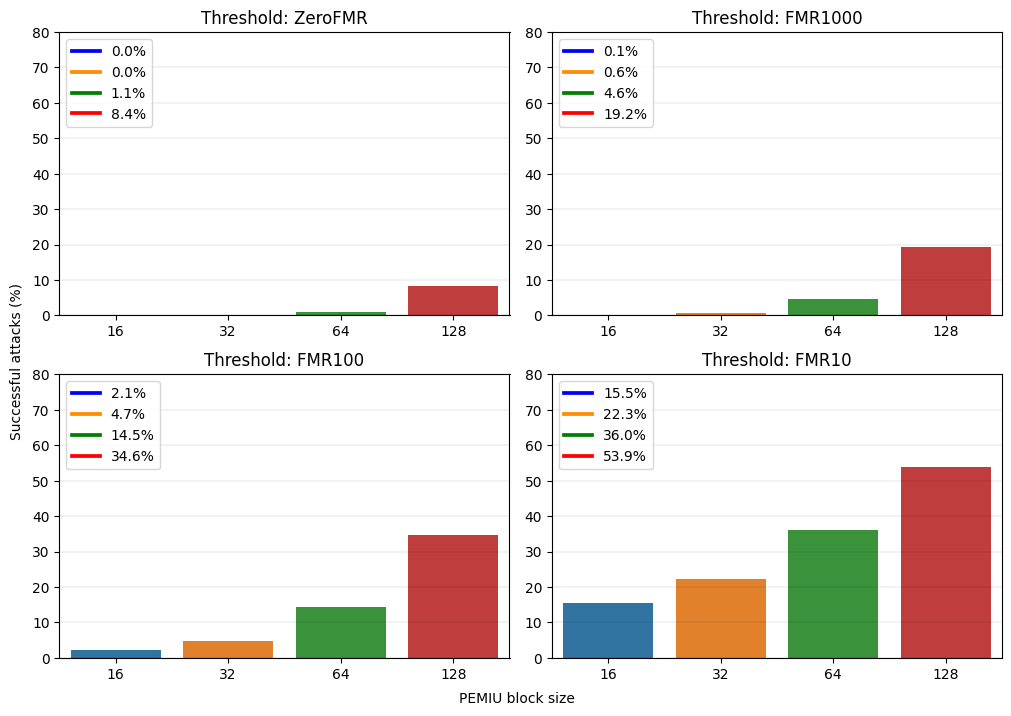

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 7), tight_layout = True)

# Title
# fig.suptitle("Sucess attack rates of images reconstructed from PEMIU enhanced embeddings\n" \
#              f"at varying block sizes using {face_extractor} and grouped by different system thresholds")
#fig.suptitle(f"{face_extractor}")
# Settings
labels_th = ['ZeroFMR', 'FMR1000', 'FMR100', 'FMR10']

# 
for i, (row, ax) in enumerate(zip(df_pyeer_unprotected[['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']], fig.get_axes())):
    successful_attacks = []
    for blocksize in block_sizes:
        num = len(df_cos_sim_all[df_cos_sim_all[f'cos_sim_pemiu{blocksize}_vs_real'] > round(df_pyeer_unprotected[row].values[0], 3)])
        num = round((num / len(df_cos_sim_all) * 100), 2)
        successful_attacks.append(num)
    ax.set_title(f"Threshold: {labels_th[i]}")
    ax.set_ylim(0, 80)
    ax.grid(visible=True, which='major', color='black', linewidth=0.075)
    #ax.set_ylabel("Successful attacks (%)")
    # ax.set_xlabel("PEMIU block size")
    sns.barplot(x=block_sizes, y=successful_attacks, ax=ax)
    ax.legend(labels=[f"{format(round(x, 1), '.1f')}%" for x in successful_attacks], loc=2)
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('darkorange')
    leg.legendHandles[2].set_color('green')
    leg.legendHandles[3].set_color('red')

fig.text(0.5, -0.01, 'PEMIU block size', ha='center')
fig.text(0, 0.37, 'Successful attacks (%)', ha='center', rotation=90)
# Render plot
plt.savefig(f'{plt_savepath}03_03_sisfe_attack_success_rates_at_thresholds.svg', bbox_inches='tight')
plt.show()

### Image quality of images reconstructed from PEMIU enhanced embeddings
- SER-FIQ quality assessment

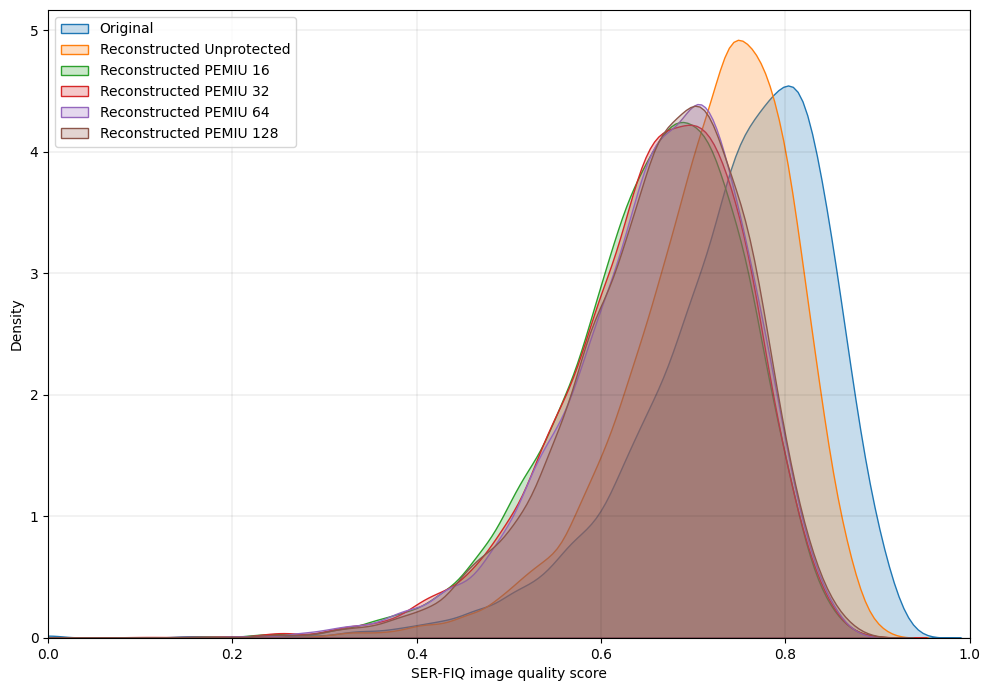

In [25]:
fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# Title
# fig.suptitle(f"Image quality comparison using {face_extractor}")
#fig.suptitle(f"{face_extractor}")
# Settings
labels_th = ['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']
colors = ["b", "r", "g", "c"]
labels = ["Original", "Reconstructed Unprotected"]

sns.kdeplot(df_image_quality_arcface[f'quality_img_original'], ax=ax, label=f"Original", fill=True)
sns.kdeplot(df_image_quality_arcface[f'quality_img_reconstructed'], ax=ax, label=f"Reconstructed Unprotected", fill=True)
for blocksize in block_sizes:
    sns.kdeplot(df_image_quality_arcface[f'quality_img_pemiu_{blocksize}'], ax=ax, label=f"Reconstructed PEMIU {blocksize}", fill=True)
# ax.set_title(f"Reconstructed")

for i, (ax) in enumerate( fig.get_axes() ):
    # sns.kdeplot(df[f'cos_sim_bonafide_synthesized_pemiu{blocksize}_normalized'], ax=ax, label=f"PEMIU protected", fill=True)
    # ax.set_xlim(0, 1)
    # ax.set_ylim(0, 7.5)
    ax.label_outer()
    ax.legend(loc=2)
    ax.set(xlabel="SER-FIQ image quality score")
    
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
# Render plot
plt.xlim([0, 1])
plt.savefig(f'{plt_savepath}03_04_image_quality_original_reconstrcuted_pemiu.svg', bbox_inches='tight')
plt.show()

### Image quality mean and standard deviation
- SER-FIQ quality assessment

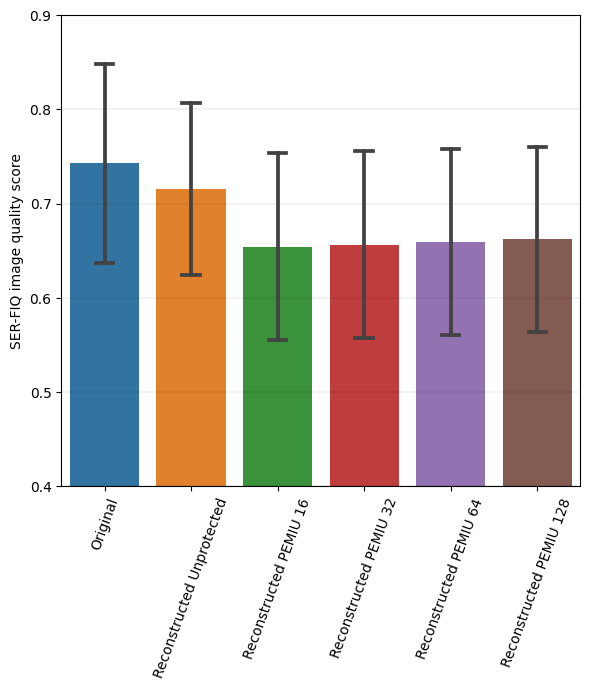

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)

# Title
# fig.suptitle(f"Mean image quality and standard deviation using {face_extractor}")
#fig.suptitle(f"{face_extractor}")
labels = ["Original", "Reconstructed Unprotected", "Reconstructed PEMIU 16",
          "Reconstructed PEMIU 32", "Reconstructed PEMIU 64", "Reconstructed PEMIU 128"]
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
sns.barplot(data=df_image_quality_arcface[df_image_quality_arcface.columns[pd.Series(df_image_quality_arcface.columns).str.startswith('quality')]], 
            ax=ax, 
            estimator=np.mean, errorbar=('sd'), capsize=.2)
ax.set(ylabel="SER-FIQ image quality score")
ax.set_xticklabels(labels, rotation=70)
plt.ylim([0.4, 0.9])
plt.savefig(f'{plt_savepath}03_05_image_quailty_mean_std.svg', bbox_inches='tight')
plt.show()

In [27]:
df_cos_sim_all.T

0                 1      \
filename                       Aaron_Eckhart_0001  Aaron_Guiel_0001   
cos_sim_reconstructed_vs_real            0.419634          0.271073   
cos_sim_pemiu16_vs_real                  -0.05259         -0.049463   
cos_sim_pemiu32_vs_real                  0.004599          0.069386   
cos_sim_pemiu64_vs_real                  0.136084           0.04484   
cos_sim_pemiu128_vs_real                 0.339503           0.18234   

                                              2                   3      \
filename                       Aaron_Patterson_0001  Aaron_Peirsol_0001   
cos_sim_reconstructed_vs_real              0.339001             0.33886   
cos_sim_pemiu16_vs_real                    0.138131           -0.038181   
cos_sim_pemiu32_vs_real                   -0.021905            0.025382   
cos_sim_pemiu64_vs_real                   -0.047909           -0.025505   
cos_sim_pemiu128_vs_real                   0.132808            0.059249   

                                            4                   5      \
filename                       Aaron_Peirsol_0002  Aaron_Peirsol_0003   
cos_sim_reconstructed_vs_real             0.44791            0.542268   
cos_sim_pemiu16_vs_real                 -0.022854           -0.031657   
cos_sim_pemiu32_vs_real                 -0.087568           -0.026239   
cos_sim_pemiu64_vs_real                 -0.048832            0.006904   
cos_sim_pemiu128_vs_real                 0.115987           -0.110291   

                                            6                7      \
filename                       Aaron_Peirsol_0004  Aaron_Pena_0001   
cos_sim_reconstructed_vs_real            0.389671         0.440148   
cos_sim_pemiu16_vs_real                 -0.020689         0.047002   
cos_sim_pemiu32_vs_real                 -0.066798         0.115017   
cos_sim_pemiu64_vs_real                  0.082643          0.23929   
cos_sim_pemiu128_vs_real                  0.07511         0.125456   

                                           8                  9      ...  \
filename                       Aaron_Sorkin_0001  Aaron_Sorkin_0002  ...   
cos_sim_reconstructed_vs_real           0.307352           0.452055  ...   
cos_sim_pemiu16_vs_real                 0.050479          -0.023529  ...   
cos_sim_pemiu32_vs_real                 0.099891           0.081902  ...   
cos_sim_pemiu64_vs_real                 0.090713           0.082379  ...   
cos_sim_pemiu128_vs_real                0.209507           0.000488  ...   

                                       13223                13224  \
filename                       Zoe_Ball_0001  Zoran_Djindjic_0001   
cos_sim_reconstructed_vs_real       0.582888             0.490273   
cos_sim_pemiu16_vs_real             0.042473             0.069887   
cos_sim_pemiu32_vs_real            -0.020302             0.050728   
cos_sim_pemiu64_vs_real             0.262991             0.114628   
cos_sim_pemiu128_vs_real             0.10952            -0.059488   

                                             13225                13226  \
filename                       Zoran_Djindjic_0002  Zoran_Djindjic_0003   
cos_sim_reconstructed_vs_real             0.443351             0.468363   
cos_sim_pemiu16_vs_real                  -0.061291              0.13025   
cos_sim_pemiu32_vs_real                   0.087727             0.176712   
cos_sim_pemiu64_vs_real                   0.121101            -0.001016   
cos_sim_pemiu128_vs_real                  0.275769             0.027838   

                                             13227                13228  \
filename                       Zoran_Djindjic_0004  Zorica_Radovic_0001   
cos_sim_reconstructed_vs_real             0.408235             0.622873   
cos_sim_pemiu16_vs_real                  -0.061415             0.027086   
cos_sim_pemiu32_vs_real                   0.082576             0.137468   
cos_sim_pemiu64_vs_real                     0.0576             0.166098   
cos_sim_pemiu128_vs_real

In [28]:
'Aaron_Eckhart_0001' in df_gender_pred_from_predicted_labels['filename'].tolist()

True

In [57]:
def get_original_image(filename):
    return f"../data/lfw_align/{'_'.join(filename.split('_')[:-1])}/{filename}.png"

def get_reconstructed_image(filename):
    path = f"{experiment_7_path}sample_images_unprotected"
    return f"{path}/{filename}_reconstructed.png"

def get_pemiu_image(filename, blocksize):
    path = f"{experiment_7_path}sample_images_pemiu{blocksize}"
    return f"{path}/{filename}_pemiu{blocksize}.png"

def get_cos_sim(filename, blocksize=False):
    if blocksize:
        #return format(round(df_gender_pred_th1000_predicted_labels[df_gender_pred_th1000_predicted_labels['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_pemiu{blocksize}'].tolist()[0], 2), '.2f')
        return format(round(df_cos_sim_all[df_cos_sim_all['filename'] == f'{filename}'][f'cos_sim_pemiu{blocksize}_vs_real'].tolist()[0], 2), '.2f')
    else:
        #return format(round(df_gender_pred_th1000_predicted_labels[df_gender_pred_th1000_predicted_labels['filename'] == f'{filename}'][f'cos_sim_bonafide_synthesized_unprotected'].tolist()[0], 2), '.2f')
        return format(round(df_cos_sim_all[df_cos_sim_all['filename'] == f'{filename}'][f'cos_sim_reconstructed_vs_real'].tolist()[0], 2), '.2f')
    
def get_gender_prediction(filename, blocksize):
    gender_pred = f"{df_gender_pred_th1000_predicted_labels[df_gender_pred_th1000_predicted_labels['filename'] == f'{filename}'][f'pred_fromimg_{blocksize}_svm_poly'].tolist()[0]}¹"
    
    if str(gender_pred)[:3] == 'nan':
        gender_pred = f"{df_gender_pred_th100_predicted_labels[df_gender_pred_th100_predicted_labels['filename'] == f'{filename}'][f'pred_fromimg_{blocksize}_svm_poly'].tolist()[0]}¹"
    
    if str(gender_pred)[:3] == 'nan' and filename in df_gender_pred_from_predicted_labels['filename'].tolist():
        gender_pred = f"{df_gender_pred_from_predicted_labels[df_gender_pred_from_predicted_labels['filename'] == f'{filename}'][f'pred_fromimg_{blocksize}_svm_sigmoid'].tolist()[0]}²"
       
    if str(gender_pred)[:3] == 'nan':
        gender_pred = f"{df_insightface_prediction[df_insightface_prediction['filename'] == f'{filename}'][f'gender_insightface_img_pemiu_{blocksize}'].tolist()[0]}³"

    return gender_pred

def get_gender(filename):
    return df_gender_pred_th1000_predicted_labels[df_gender_pred_th1000_predicted_labels['filename'] == f'{filename}'][f'gender_official'].tolist()[0]

def get_gender_color(gender: str):
    return 'skyblue' if gender[:1] == 'M' else 'lightpink'
    
def display_image(filename, display_title=False):
    # display images
    fig, ax = plt.subplots(1,3)
    
    if display_title:
        ax[0].set_title(f"Original", pad=10)
        ax[1].set_title("Reconstructed", pad=10)
        ax[2].set_title("Pemiu 16", pad=10)
    
    gender_color_prediction ='skyblue' if get_gender_prediction(filename, '16') == 'M' else 'lightpink'
    gender_color ='skyblue' if get_gender(filename) == 'M' else 'lightpink'
    
    # Display cosine similarity score
    ax[0].text(4, 152, f"{filename}", fontsize=8, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    if gender_prediction_toggle:
        ax[0].text(140, 150, get_gender(filename), fontsize=14, c=gender_color, bbox=dict(facecolor='black', alpha=0.5))
    ax[1].text(82, 105, get_cos_sim(filename), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[2].text(82, 105, get_cos_sim(filename, '16'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    if gender_prediction_toggle:
        if str(get_gender_prediction(filename, '16')) != 'nan':
            ax[2].text(3,105, get_gender_prediction(filename, '16'), fontsize=14, c=get_gender_color(get_gender_prediction(filename, '16')), bbox=dict(facecolor='black', alpha=0.5))

    ax[0].imshow(mpimg.imread(get_original_image(filename)))
    ax[1].imshow(mpimg.imread(get_reconstructed_image(filename)))
    ax[2].imshow(mpimg.imread(get_pemiu_image(filename, "16")))
     
    for x in range(0, 3):
        ax[x].axis('off')
        
def display_image_pemiu(filename, display_title=False):
    # display images
    fig, ax = plt.subplots(1,3)
    
    titles = ["Pemiu 32", "Pemiu 64", "Pemiu 128"]
    if display_title:
        for idx, title in enumerate(titles):
            ax[idx].set_title(title, pad=10)
    
    # Cos sim display
    ax[0].text(82, 105, get_cos_sim(filename, '32'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[1].text(82, 105, get_cos_sim(filename, '64'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    ax[2].text(82, 105, get_cos_sim(filename, '128'), fontsize=14, c='yellow', bbox=dict(facecolor='black', alpha=0.5))
    
    # Gender prediction
    if gender_prediction_toggle:
        if str(get_gender_prediction(filename, '32')) != 'nan':
            ax[0].text(3,105, get_gender_prediction(filename, '32'), fontsize=14, 
                       c=get_gender_color(get_gender_prediction(filename, '32')), bbox=dict(facecolor='black', alpha=0.5))
        if str(get_gender_prediction(filename, '64')) != 'nan':
            ax[1].text(3,105, get_gender_prediction(filename, '64'), fontsize=14, 
                       c=get_gender_color(get_gender_prediction(filename, '64')), bbox=dict(facecolor='black', alpha=0.5))
        if str(get_gender_prediction(filename, '128')) != 'nan':
            ax[2].text(3,105, get_gender_prediction(filename, '128'), fontsize=14, 
                       c=get_gender_color(get_gender_prediction(filename, '128')), bbox=dict(facecolor='black', alpha=0.5))
    
    ax[0].imshow(mpimg.imread(get_pemiu_image(filename, "32")))
    ax[1].imshow(mpimg.imread(get_pemiu_image(filename, "64")))
    ax[2].imshow(mpimg.imread(get_pemiu_image(filename, "128")))
     
    for x in range(0, 3):
        ax[x].axis('off')

In [58]:
gender_prediction_toggle = False

### Visual inspection of images reconstructed from PEMIU enhanced templates

In [59]:
df_gender_pred_from_predicted_labels.T

0      \
filename                                                                           Aaron_Eckhart_0001   
img_original_quality                                                                         0.785188   
pemiu16_fromimg                                     experiments/experiment_7_model1_pemiu_block_si...   
pemiu32_fromimg                                     experiments/experiment_7_model1_pemiu_block_si...   
pemiu64_fromimg                                     experiments/experiment_7_model1_pemiu_block_si...   
pemiu128_fromimg                                    experiments/experiment_7_model1_pemiu_block_si...   
pemiu0_fromimg                                      experiments/experiment_7_model1_pemiu_block_si...   
pemiu16                                             ../data/features_cleaner_pemiu16/Aaron_Eckhart...   
pemiu32                                             ../data/features_cleaner_pemiu32/Aaron_Eckhart...   
pemiu64                                             ../data/features_cleaner_pemiu64/Aaron_Eckhart...   
pemiu128                                            ../data/features_cleaner_pemiu128/Aaron_Eckhar...   
pemiu0                                                ../data/features_cleaner/Aaron_Eckhart_0001.npy   
gender_official                                                                                     M   
cos_sim_bonafide_synthesized_pemiu16_normalized                                              0.200561   
cos_sim_bonafide_synthesized_pemiu32_normalized                                              0.245139   
cos_sim_bonafide_synthesized_pemiu64_normalized                                              0.347631   
cos_sim_bonafide_synthesized_pemiu128_normalized                                             0.506194   
cos_sim_bonafide_synthesized_unprotected_normal...                                           0.568656   
order                                                                                               0   
pred_fromimg_16_knn                                                                                 M   
pred_fromimg_32_knn                                                                                 F   
pred_fromimg_64_knn                                                                                 M   
pred_fromimg_128_knn                                                                                M   
pred_fromimg_16_svm_poly                                                                            M   
pred_fromimg_32_svm_poly                                                                            M   
pred_fromimg_64_svm_poly                                                                            F   
pred_fromimg_128_svm_poly                                                                           M   
pred_fromimg_16_svm_rbf                                                                             M   
pred_fromimg_32_svm_rbf                                                                             M   
pred_fromimg_64_svm_rbf                                                                             F   
pred_fromimg_128_svm_rbf                                                                            M   
pred_fromimg_16_svm_sigmoid                                                                         M   
pred_fromimg_32_svm_sigmoid                                                                         M   
pred_fromimg_64_svm_sigmoid                                                                         F   
pred_fromimg_128_svm_sigmoid                                                                        M   
pred_fromembedding_16_knn                                                                           M   
pred_fromembedding_32_knn                                                                           M   
pred_fromembedding_64_knn                                                                           M   
p

In [60]:
df_gender_pred_th100_predicted_labels.T

0     \
filename                                                                           Aaron_Eckhart_0001   
img_original_quality                                                                         0.785188   
pemiu16_fromimg                                     experiments/experiment_7_model1_pemiu_block_si...   
pemiu32_fromimg                                     experiments/experiment_7_model1_pemiu_block_si...   
pemiu64_fromimg                                     experiments/experiment_7_model1_pemiu_block_si...   
pemiu128_fromimg                                    experiments/experiment_7_model1_pemiu_block_si...   
pemiu0_fromimg                                      experiments/experiment_7_model1_pemiu_block_si...   
pemiu16                                             ../data/features_cleaner_pemiu16/Aaron_Eckhart...   
pemiu32                                             ../data/features_cleaner_pemiu32/Aaron_Eckhart...   
pemiu64                                             ../data/features_cleaner_pemiu64/Aaron_Eckhart...   
pemiu128                                            ../data/features_cleaner_pemiu128/Aaron_Eckhar...   
pemiu0                                                ../data/features_cleaner/Aaron_Eckhart_0001.npy   
gender_official                                                                                     M   
cos_sim_bonafide_synthesized_pemiu16_normalized                                              0.200561   
cos_sim_bonafide_synthesized_pemiu32_normalized                                              0.245139   
cos_sim_bonafide_synthesized_pemiu64_normalized                                              0.347631   
cos_sim_bonafide_synthesized_pemiu128_normalized                                             0.506194   
cos_sim_bonafide_synthesized_unprotected_normal...                                           0.568656   
pred_fromimg_16_knn                                                                               NaN   
pred_fromimg_32_knn                                                                               NaN   
pred_fromimg_64_knn                                                                                 M   
pred_fromimg_128_knn                                                                                M   
pred_fromimg_16_svm_poly                                                                          NaN   
pred_fromimg_32_svm_poly                                                                          NaN   
pred_fromimg_64_svm_poly                                                                            F   
pred_fromimg_128_svm_poly                                                                           M   
pred_fromimg_16_svm_rbf                                                                           NaN   
pred_fromimg_32_svm_rbf                                                                           NaN   
pred_fromimg_64_svm_rbf                                                                             F   
pred_fromimg_128_svm_rbf                                                                            M   
pred_fromimg_16_svm_sigmoid                                                                       NaN   
pred_fromimg_32_svm_sigmoid                                                                       NaN   
pred_fromimg_64_svm_sigmoid                                                                         F   
pred_fromimg_128_svm_sigmoid                                                                        M   
pred_fromembedding_16_knn                                                                         NaN   
pred_fromembedding_32_knn                                                                         NaN   
pred_fromembedding_64_knn                                                                           M   
pred_fromembedding_128_knn                                                                          M   
pr

In [61]:
# Create dataframe holding filenames of PEMIU enhanced recontructions that pass FMR1000_TH
filenames_pass_th1000_df = pd.DataFrame(df_gender_pred_th1000_predicted_labels[df_gender_pred_th1000_predicted_labels['cos_sim_bonafide_synthesized_pemiu16_normalized'] > 0.40])
filenames_pass_th1000 = []
for i in range(len(df_gender_pred_th1000_predicted_labels)):
    if df_gender_pred_th1000_predicted_labels.iloc[i]['gender_official'] == df_gender_pred_th1000_predicted_labels.iloc[i]['pred_fromimg_16_svm_poly']:
        filenames_pass_th1000.append(df_gender_pred_th1000_predicted_labels.iloc[i]['filename'])
# Sort by greatest cos_sim
filenames_pass_th1000_df.sort_values(by="cos_sim_bonafide_synthesized_pemiu16_normalized", axis=0, ascending=False, inplace=True)

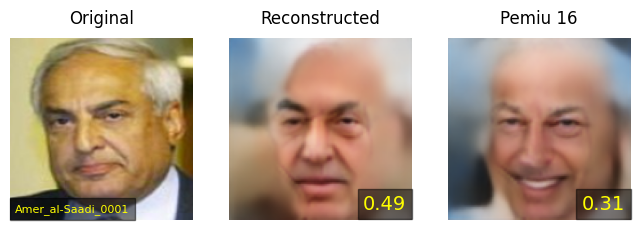

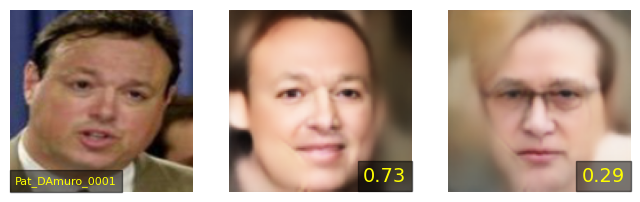

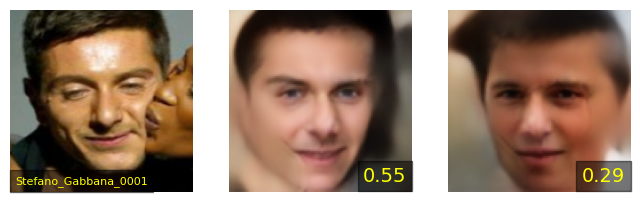

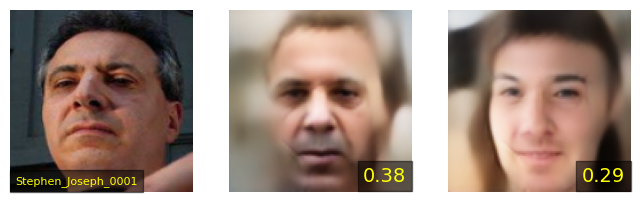

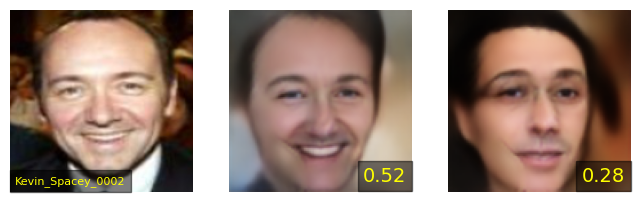

In [62]:
# Highest cos_sim for male subjects
for index, name in enumerate(filenames_pass_th1000_df['filename']):
    if index == 0:
        display_image(name, display_title=True)
    elif index < 5:
        display_image(name)
    else:
        break
    plt.savefig(f'{plt_savepath}03_06_{index}_visual_inspection_male_real_reconstrcuted_pemiu16.svg', bbox_inches='tight')

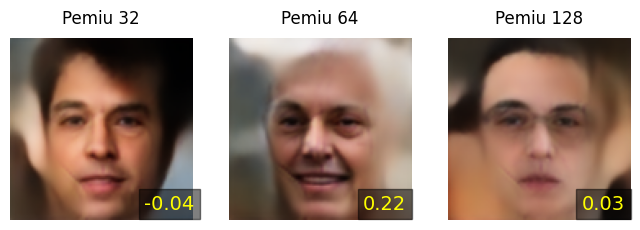

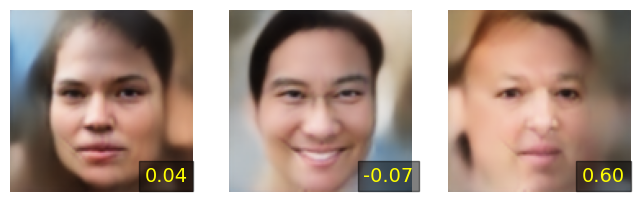

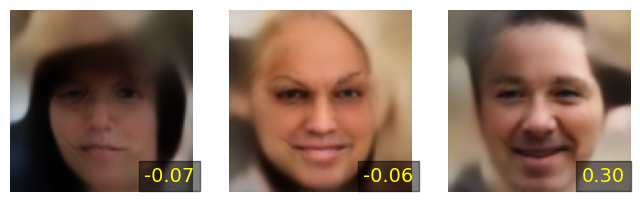

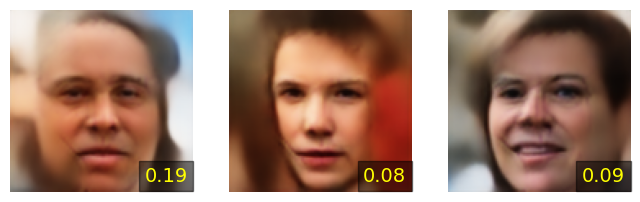

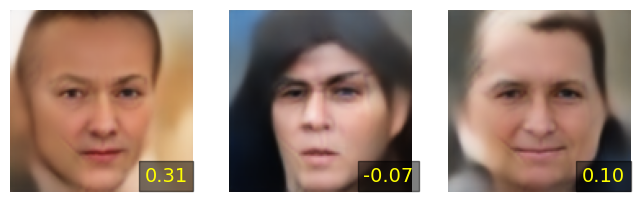

In [63]:
# Highest cos_sim for male subjects cont.
for index, name in enumerate(filenames_pass_th1000_df['filename']):
    if index == 0:
        display_image_pemiu(name, display_title=True)
    elif index < 5:
        display_image_pemiu(name)
    else:
        break
    plt.savefig(f'{plt_savepath}03_07_{index}_visual_inspection_male_pemiu_32_64_128.svg', bbox_inches='tight')

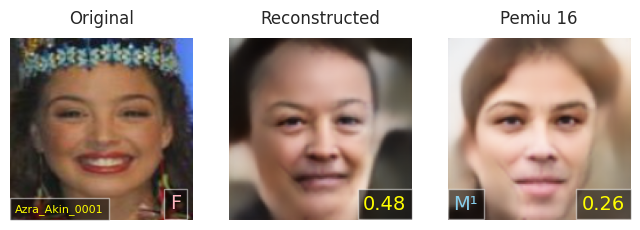

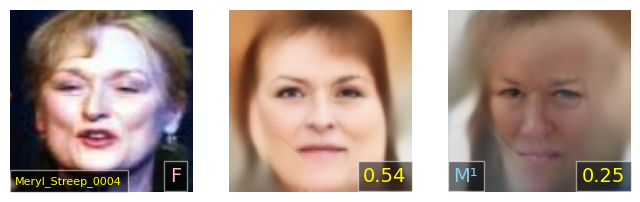

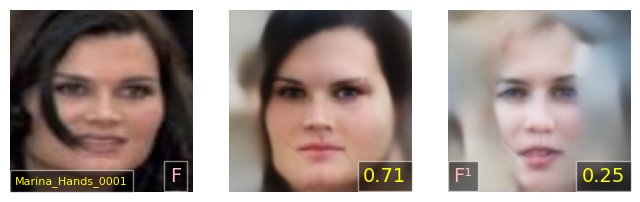

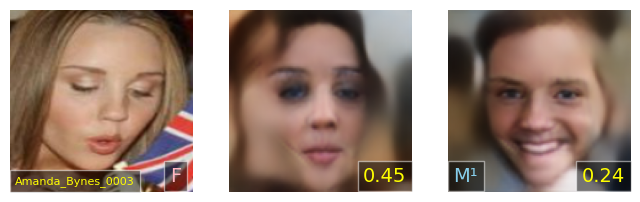

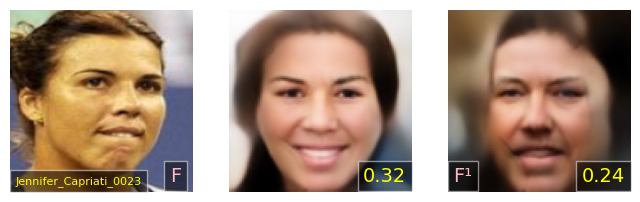

In [168]:
# Highest cos_sim for female subjects
for index, name in enumerate(filenames_pass_th1000_df[filenames_pass_th1000_df['gender_official'] == 'F']['filename']):
    if index == 0:
        display_image(name, True)
    elif index < 5:
        display_image(name)
    else:
        break
    plt.savefig(f'{plt_savepath}03_08_{index}_visual_inspection_female_real_reconstrcuted_pemiu16.svg', bbox_inches='tight')

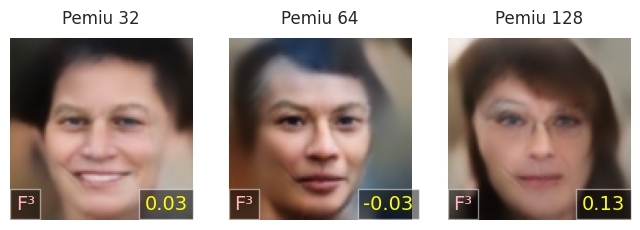

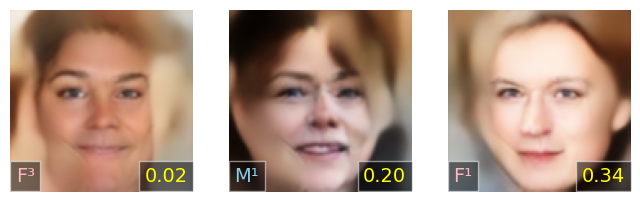

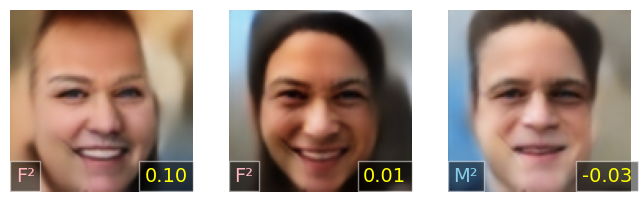

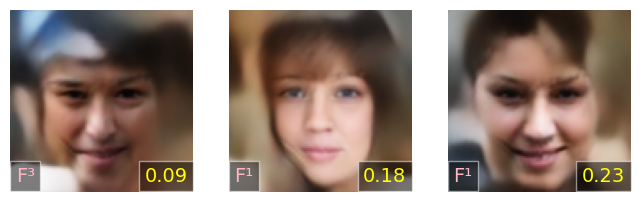

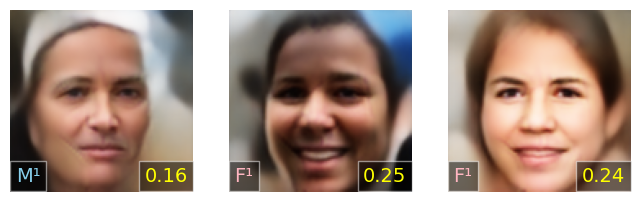

In [169]:
# Highest cos_sim for female subjects
for index, name in enumerate(filenames_pass_th1000_df[filenames_pass_th1000_df['gender_official'] == 'F']['filename']):
    if index == 0:
        display_image_pemiu(name, True)
    elif index < 5:
        display_image_pemiu(name)
    else:
        break
    plt.savefig(f'{plt_savepath}03_09_{index}_visual_inspection_female_pemiu_32_64_128.svg', bbox_inches='tight')

---

## 4. Attribute prediction (gender) on PEMIU enhanced embeddings

- Dataset: LFW (13.233 images)
- Labels (M/F) from official source

Prediction using
1. KNN on embedding
2. SVM on embedding
3. InsightFace on synthesized face images

### Gender distribution of original LFW dataset 

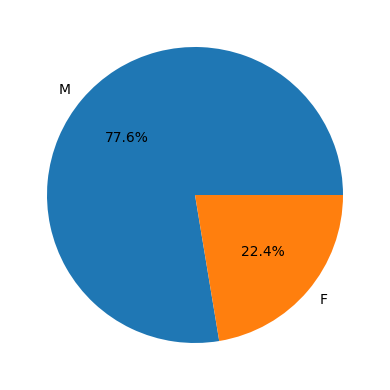

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4), tight_layout = True)
# fig.suptitle("Gender distribution of original LFW dataset")
num_m = len(df_pairs_gender[df_pairs_gender["gender_official"]=="M"])
num_f = len(df_pairs_gender[df_pairs_gender["gender_official"]=="F"])
plt.pie([num_m, num_f], labels=['M', 'F'], autopct='%1.1f%%')
plt.savefig(f'{plt_savepath}04_01_gender_distribution_lfw_original.svg', bbox_inches='tight')
plt.show()

### Data preparation

For evaluation the LFW dataset is used, consisting of 13,233 samples. The original gender distribution of the LFW dataset is 77.6% male.

Data preparation
1. The official list of gender labels downloaded from the LFW website is missing four samples. Those four samples are dropped from the dataset.
2. The best sample for each identity is chosen using SER-FIQ Face Image Quality Assessment. We reduce the dataset to include only one sample per identity: 5,749 samples.
3. The dataset contains 1,471 female and 4,378 male identities. This gender unbalance negatively influences the training results. Therefore, we reduce the number of male identities to match the amount of female identities. This yields a dataset containing 2,942 identities.
4. We sort the dataset to alternate between one male and one female sample to make sure that in each k-fold, we always have a balanced set of samples in regard to gender.

### Setup

ML algorithms:
- KNN
- SVM: Poly
- SVM: RBF
- SVM: Sigmoid

Dataset:
- LFW
- Balanced for gender equality

Training:
- Model is trained using the corresponding embeddings, e.g. for PEMIU blocksize 16, the training and testing is performed using embeddings of blocksize 16

Evaluation method:
- From embedding: Evaluation from unprotected and privacy enhanced (PEMIU) embeddings
- From image: Evaluation on embeddings created from reconstrcuted images produced from unprotected and privacy enhanced (PEMIU) embeddings


### Attribute prediction using ML and k-fold cross validation

Workflow:
- Introduce k-fold cross validation with 10 folds
- Calculate arithmetic mean as final result
- Only one sample per identity: Best quality
- Include standard deviation ("_std")

In [7]:
# From embedding
df_gender_pred_cv_from_embedding.loc[0, ['blocksize']] = 'Unprotected'
# df_gender_pred_cv_from_embedding

In [8]:
df_gender_pred_cv_from_img.loc[0, ['blocksize']] = 'Unprotected'


display = pd.DataFrame()

display['blocksize'] = df_gender_pred_cv_from_img['blocksize']
display['knn'] =  df_gender_pred_cv_from_img['knn_mean'].apply(lambda x: f"{format(round(x, 2), '.2f')} ± ")
display['knn_std'] = df_gender_pred_cv_from_img['knn_std'].apply(lambda x: f"{format(round(x, 2), '.2f')},")
display['poly'] = df_gender_pred_cv_from_img['svm_poly_mean'].apply(lambda x: f"{format(round(x, 2), '.2f')} ± ")
display['poly_std'] = df_gender_pred_cv_from_img['svm_poly_std'].apply(lambda x: f"{format(round(x, 2), '.2f')},")
display['rbf'] = df_gender_pred_cv_from_img['svm_rbf_mean'].apply(lambda x: f"{format(round(x, 2), '.2f')} ± ")
display['rbf_std'] = df_gender_pred_cv_from_img['svm_rbf_std'].apply(lambda x: f"{format(round(x, 2), '.2f')},")
display['sigmoid'] = df_gender_pred_cv_from_img['svm_sigmoid_mean'].apply(lambda x: f"{format(round(x, 2), '.2f')} ± ")
display['sigmoid_std'] = df_gender_pred_cv_from_img['svm_sigmoid_std'].apply(lambda x: f"{format(round(x, 2), '.2f')}")
display
#df_gender_pred_cv_from_img

blocksize      knn knn_std     poly poly_std      rbf rbf_std  sigmoid  \
0  Unprotected  0.70 ±    0.02,  0.81 ±     0.02,  0.89 ±    0.01,  0.85 ±    
1           16  0.51 ±    0.03,  0.50 ±     0.03,  0.50 ±    0.03,  0.49 ±    
2           32  0.51 ±    0.02,  0.50 ±     0.03,  0.50 ±    0.02,  0.50 ±    
3           64  0.51 ±    0.02,  0.52 ±     0.02,  0.53 ±    0.03,  0.52 ±    
4          128  0.53 ±    0.03,  0.55 ±     0.02,  0.57 ±    0.02,  0.56 ±    

  sigmoid_std  
0        0.02  
1        0.02  
2        0.01  
3        0.03  
4        0.01

In [9]:
df_gender_pred_cv_from_img

blocksize  knn_mean  knn_std  svm_poly_mean  svm_poly_std  svm_rbf_mean  \
0  Unprotected    0.6958   0.0203         0.8096        0.0151        0.8922   
1           16    0.5085   0.0331         0.5048        0.0267        0.5017   
2           32    0.5129   0.0177         0.5030        0.0257        0.5034   
3           64    0.5061   0.0216         0.5156        0.0238        0.5333   
4          128    0.5279   0.0322         0.5496        0.0178        0.5738   

   svm_rbf_std  svm_sigmoid_mean  svm_sigmoid_std  
0       0.0133            0.8549           0.0167  
1       0.0265            0.4922           0.0190  
2       0.0172            0.4980           0.0145  
3       0.0346            0.5167           0.0342  
4       0.0238            0.5642           0.0141

### Attack scenario: Predict gender of PEMIU protected embeddings

- Train model on images reconstructed from unprotected embeddings
- Test model on images created from PEMIU protected embeddings
- For each identity, only the sample with the highest image quality (SER_FIQ) is used for prediction

In [25]:
df_gender_pred_from_img.iloc[:, 0:5].apply(lambda x: round(x, 5)*100)

blocksize     knn  svm_poly  svm_rbf  svm_sigmoid
0       1600  50.714    50.374   51.054       51.496
1       3200  49.898    50.612   51.801       52.005
2       6400  51.156    54.521   54.181       54.555
3      12800  56.220    59.959   59.891       58.566

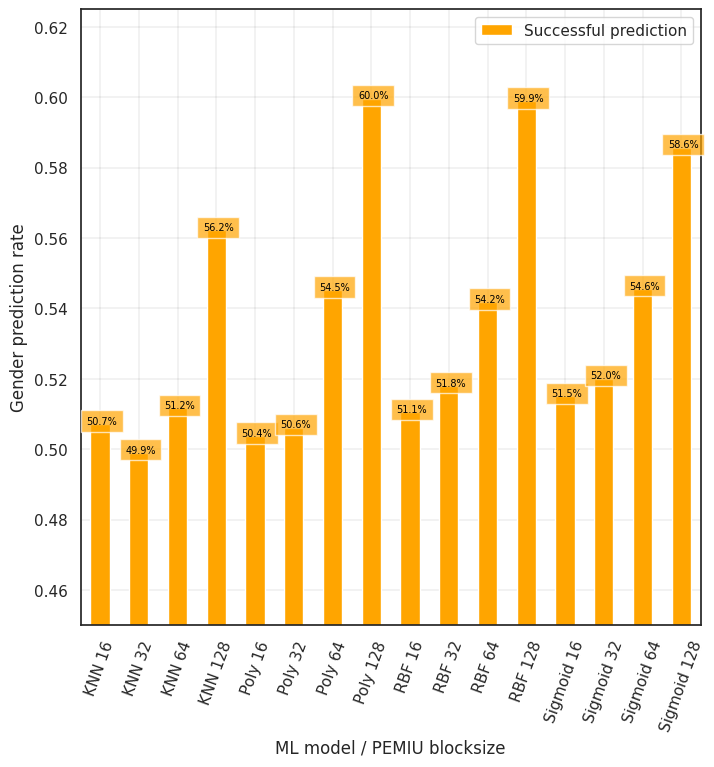

In [11]:
# Successfully predicted samples

df = df_gender_pred_from_img.T.iloc[1:, :]
df.reset_index()
df.index.name = 'Model'
df_numbers = df.to_numpy().flatten()
df_numbers = pd.DataFrame(df_numbers)
df_numbers.index.name = 'Model'
df_numbers.rename({0: 'Successful prediction'}, axis=1, inplace=True)

# set seaborn plotting aesthetics
sns.set(style='white')
labels = ['KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128']

#create stacked bar chart
fig, ax = plt.subplots()
df_numbers.plot(kind='bar', color=['orange'], ax=ax, zorder=2, label=['Successful predictions'])
# df_results_correct_prediction.iloc[0:16,[0,2]].set_index('Model').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Gender prediction rate')
# ax.set_title(f"Gender prediction attack on synthesized imagesusing {face_extractor}\n with a balanced dataset")
#ax.set_title(f"{face_extractor}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)

for index, p in enumerate(ax.patches):
    if index < 16:
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f"{round(df_numbers['Successful prediction'].tolist()[index]*100, 1)}%", (x-0.2, y), ha='center', fontweight='normal', fontsize=7, c='black', bbox=dict(facecolor='orange', alpha=0.7))
        # ax.annotate(f'{percentage}%', (x-0.1, y+50), ha='center', fontsize=9)
plt.ylim([0.45, 0.625])
plt.savefig(f'{plt_savepath}04_02_gender_predict_ml_success_rate.svg', bbox_inches='tight')
plt.show()

In [19]:
len(df_gender_pred_from_img)

4

### Attack: Predict gender of PEMIU protected embeddings, but only on samples where the synthesized image passes the FMR100 threshold

Workflow:
- Balance the dataset to include same amount of male and female samples
- Train model on unprotected templates and official gender labels
- Filter the dataset to only include the samples that pass the FMR100 threshold (meaning: where the cosine similarity is greater than 0.34)
- Predict labels only on filtered dataset

In [28]:
df_gender_pred_th100_from_img.iloc[:, 0:5].apply(lambda x: round(x, 8)*100)

blocksize        knn   svm_poly    svm_rbf  svm_sigmoid
0       1600  69.352708  69.352708  67.107001    65.125495
1       3200  65.940054  64.168937  61.989101    60.762943
2       6400  66.233766  65.909091  61.948052    60.454545
3      12800  73.295669  73.672316  70.244821    68.436911

In [13]:
possible_predictions_ml_eval = len(df_gender_pred_th100_predicted_labels)
print(f"Amount of possible predictions: {possible_predictions_ml_eval}")

Amount of possible predictions: 5748


In [14]:
# Number of samples that were correctly predicted by ML algorithm and blocksize
df_results_correct_prediction = pd.DataFrame()
results = []
mask_predicted = df_gender_pred_th100_predicted_labels.columns.str.contains('pred_*')
for column in df_gender_pred_th100_predicted_labels.loc[:, mask_predicted]:
    correct_predictions = 0
    for index in range(len(df_gender_pred_th100_predicted_labels)):
        if df_gender_pred_th100_predicted_labels['gender_official'][index] == df_gender_pred_th100_predicted_labels[column][index]:
            correct_predictions = correct_predictions + 1
    results.append(correct_predictions)

df_results_correct_prediction = pd.DataFrame(results).T
df_results_correct_prediction.columns = df_gender_pred_th100_predicted_labels.loc[:, mask_predicted].columns.tolist()
df_results_correct_prediction = df_results_correct_prediction.T
df_results_correct_prediction.rename(columns={0: 'Successful predictions'}, inplace=True)

# We want to calculate the percentage between the corrently classified labels and the total amount of 
# samples that were evaluated
total = []
for x in range(len(df_results_correct_prediction.index)):
    sum_of_no_predictions = sum(pd.isnull(df_gender_pred_th100_predicted_labels[df_results_correct_prediction.index.tolist()[x]]))
    sum_of_predictions = len(df_gender_pred_th100_predicted_labels) - sum_of_no_predictions
    total.append(sum_of_predictions)

df_results_correct_prediction['Possible predictions'] = total

# Reset index for sns barplot to work
df_results_correct_prediction.index.name = 'Model'
df_results_correct_prediction.reset_index(inplace=True)
df_results_correct_prediction

Model  Successful predictions  \
0                  pred_fromimg_16_knn                     525   
1                  pred_fromimg_32_knn                     484   
2                  pred_fromimg_64_knn                    1020   
3                 pred_fromimg_128_knn                    1946   
4             pred_fromimg_16_svm_poly                     525   
5             pred_fromimg_32_svm_poly                     471   
6             pred_fromimg_64_svm_poly                    1015   
7            pred_fromimg_128_svm_poly                    1956   
8              pred_fromimg_16_svm_rbf                     508   
9              pred_fromimg_32_svm_rbf                     455   
10             pred_fromimg_64_svm_rbf                     954   
11            pred_fromimg_128_svm_rbf                    1865   
12         pred_fromimg_16_svm_sigmoid                     493   
13         pred_fromimg_32_svm_sigmoid                     446   
14         pred_fromimg_64_svm_sigmoid                     931   
15        pred_fromimg_128_svm_sigmoid                    1817   
16           pred_fromembedding_16_knn                     540   
17           pred_fromembedding_32_knn                     528   
18           pred_fromembedding_64_knn                    1090   
19          pred_fromembedding_128_knn                    2027   
20      pred_fromembedding_16_svm_poly                     538   
21      pred_fromembedding_32_svm_poly                     525   
22      pred_fromembedding_64_svm_poly                    1089   
23     pred_fromembedding_128_svm_poly                    2119   
24       pred_fromembedding_16_svm_rbf                     492   
25       pred_fromembedding_32_svm_rbf                     465   
26       pred_fromembedding_64_svm_rbf                    1066   
27      pred_fromembedding_128_svm_rbf                    2014   
28   pred_fromembedding_16_svm_sigmoid                     446   
29   pred_fromembedding_32_svm_sigmoid                     424   
30   pred_fromembedding_64_svm_sigmoid                     956   
31  pred_fromembedding_128_svm_sigmoid                    1649   

    Possible predictions  
0                    757  
1                    734  
2                   1540  
3                   2655  
4                    757  
5                    734  
6                   1540  
7                   2655  
8                    757  
9                    734  
10                  1540  
11                  2655  
12                   757  
13                   734  
14                  1540  
15                  2655  
16                   757  
17                   734  
18                  1540  
19                  2655  
20                   757  
21                   734  
22                  1540  
23                  2655  
24                   757  
25                   734  
26                  1540  
27                  2655  
28                   757  
29                   734  
30                  1540  
31                  2655

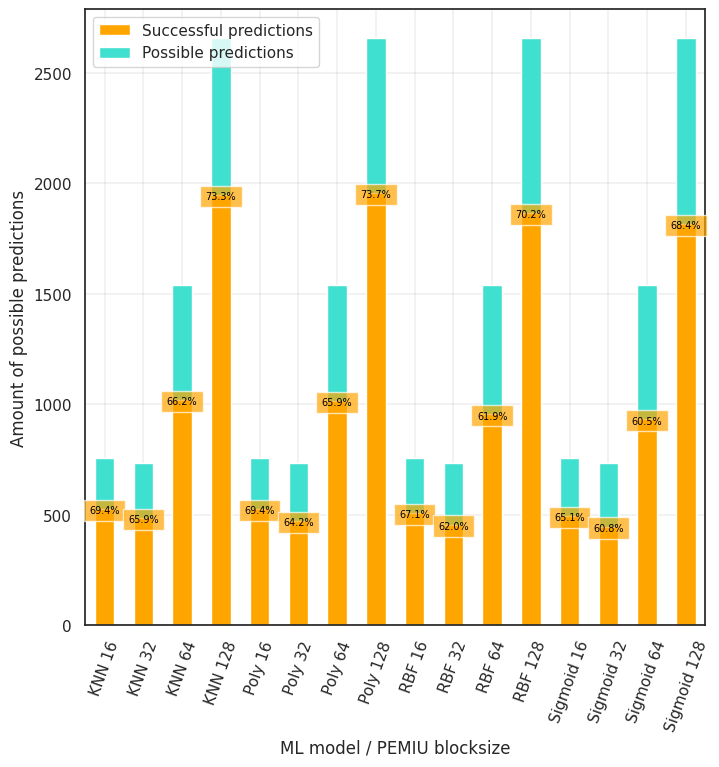

In [15]:
# Successfully predicted samples

# set seaborn plotting aesthetics
sns.set(style='white')
labels = ['KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128']

#create stacked bar chart
fig, ax = plt.subplots()
df_results_correct_prediction.iloc[0:16,0:2].set_index('Model').plot(kind='bar', color=['orange'], ax=ax, zorder=2)
df_results_correct_prediction.iloc[0:16,[0,2]].set_index('Model').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Amount of possible predictions')
# ax.set_title(f"Gender prediction attack on synthesized images using {face_extractor}\nConsidering only identities, where the reconstrcuted image passes the FMR100 threshold")
#ax.set_title(f"{face_extractor}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)

for index, p in enumerate(ax.patches):
    if index < 16:
        percentage = round(df_results_correct_prediction['Successful predictions'][index] / df_results_correct_prediction['Possible predictions'][index] * 100, 1)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}%', (x-0.25, y-20), ha='center', fontweight='normal', fontsize=7, c='black', bbox=dict(facecolor='orange', alpha=0.7))
        # ax.annotate(f'{percentage}%', (x-0.1, y+50), ha='center', fontsize=9)

plt.savefig(f'{plt_savepath}04_03_gender_predict_ml_success_rate_th100.svg', bbox_inches='tight')
plt.show()

In [16]:
possible_predictions_ml_eval
[print(f"Percentage of possible predictions per block size: {round((x / possible_predictions_ml_eval * 100), 2)}%") for x in df_results_correct_prediction['Possible predictions'][0:4].tolist()]


Percentage of possible predictions per block size: 13.17%
Percentage of possible predictions per block size: 12.77%
Percentage of possible predictions per block size: 26.79%
Percentage of possible predictions per block size: 46.19%


[None, None, None, None]

### Attack: Predict gender of PEMIU protected embeddings, but only on samples, where the synthesized image passes the FMR1000 threshold


In [23]:
df_gender_pred_th1000_from_img.apply(lambda x: round(x, 5)*100)

blocksize     knn  svm_poly  svm_rbf  svm_sigmoid
0       1600  70.588    76.471   77.647       76.471
1       3200  70.629    77.622   76.224       73.427
2       6400  64.632    69.838   68.223       66.427
3      12800  76.063    78.129   74.484       73.329

In [39]:
mask_predicted = df_gender_pred_th1000_predicted_labels.columns.str.contains('pred_*')

# Number of samples that were correctly predicted by ML algorithm and blocksize
df_results_correct_prediction = pd.DataFrame()
results = []
for column in df_gender_pred_th1000_predicted_labels.loc[:, mask_predicted]:
    correct_predictions = 0
    for index in range(len(df_gender_pred_th1000_predicted_labels)):
        if df_gender_pred_th1000_predicted_labels['gender_official'][index] == df_gender_pred_th1000_predicted_labels[column][index]:
            correct_predictions = correct_predictions + 1
    results.append(correct_predictions)
    # df_results_correct_prediction[column] = correct_predictions

df_results_correct_prediction = pd.DataFrame(results).T
df_results_correct_prediction.columns = df_gender_pred_th1000_predicted_labels.loc[:, mask_predicted].columns.tolist()
df_results_correct_prediction = df_results_correct_prediction.T
df_results_correct_prediction.rename(columns={0: 'Successful predictions'}, inplace=True)

# We want to calculate the percentage between the corrently classified labels and the total amount of 
# samples that were evaluated
total = []
for x in range(len(df_results_correct_prediction.index)):
    sum_of_no_predictions = sum(pd.isnull(df_gender_pred_th1000_predicted_labels[df_results_correct_prediction.index.tolist()[x]]))
    sum_of_predictions = len(df_gender_pred_th1000_predicted_labels) - sum_of_no_predictions
    total.append(sum_of_predictions)

df_results_correct_prediction['Possible predictions'] = total

# Reset index for sns barplot to work
df_results_correct_prediction.index.name = 'Model'
df_results_correct_prediction.reset_index(inplace=True)
df_results_correct_prediction

Model  Successful predictions  \
0                  pred_fromimg_16_knn                      60   
1                  pred_fromimg_32_knn                     101   
2                  pred_fromimg_64_knn                     360   
3                 pred_fromimg_128_knn                    1252   
4             pred_fromimg_16_svm_poly                      65   
5             pred_fromimg_32_svm_poly                     111   
6             pred_fromimg_64_svm_poly                     389   
7            pred_fromimg_128_svm_poly                    1286   
8              pred_fromimg_16_svm_rbf                      66   
9              pred_fromimg_32_svm_rbf                     109   
10             pred_fromimg_64_svm_rbf                     380   
11            pred_fromimg_128_svm_rbf                    1226   
12         pred_fromimg_16_svm_sigmoid                      65   
13         pred_fromimg_32_svm_sigmoid                     105   
14         pred_fromimg_64_svm_sigmoid                     370   
15        pred_fromimg_128_svm_sigmoid                    1207   
16           pred_fromembedding_16_knn                      57   
17           pred_fromembedding_32_knn                     106   
18           pred_fromembedding_64_knn                     374   
19          pred_fromembedding_128_knn                    1276   
20      pred_fromembedding_32_svm_poly                     105   
21      pred_fromembedding_64_svm_poly                     372   
22     pred_fromembedding_128_svm_poly                    1364   
23       pred_fromembedding_16_svm_rbf                      53   
24       pred_fromembedding_32_svm_rbf                     101   
25       pred_fromembedding_64_svm_rbf                     400   
26      pred_fromembedding_128_svm_rbf                    1304   
27   pred_fromembedding_16_svm_sigmoid                      44   
28   pred_fromembedding_32_svm_sigmoid                      90   
29   pred_fromembedding_64_svm_sigmoid                     358   
30  pred_fromembedding_128_svm_sigmoid                    1041   

    Possible predictions  
0                     85  
1                    143  
2                    557  
3                   1646  
4                     85  
5                    143  
6                    557  
7                   1646  
8                     85  
9                    143  
10                   557  
11                  1646  
12                    85  
13                   143  
14                   557  
15                  1646  
16                    85  
17                   143  
18                   557  
19                  1646  
20                   143  
21                   557  
22                  1646  
23                    85  
24                   143  
25                   557  
26                  1646  
27                    85  
28                   143  
29                   557  
30                  1646

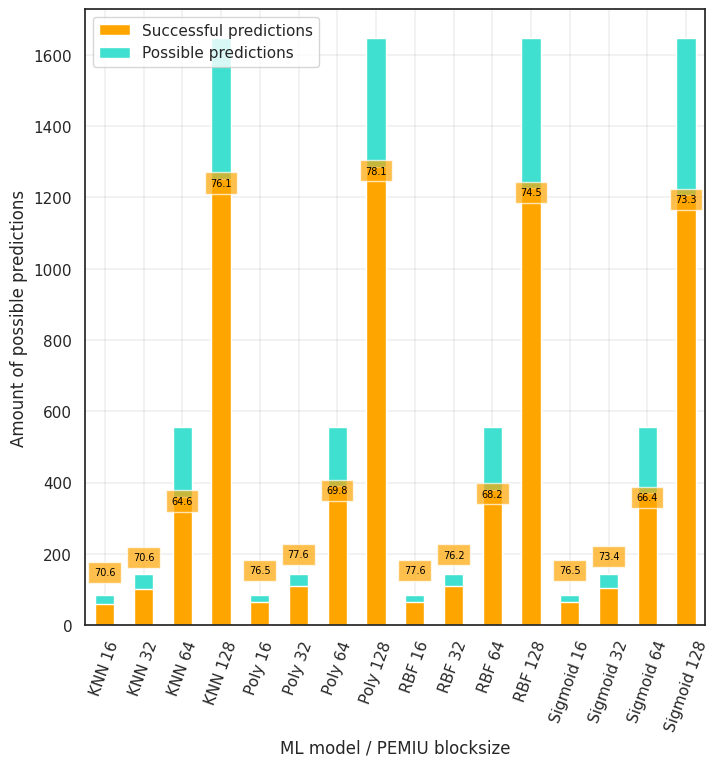

In [40]:
# Successfully predicted samples

# set seaborn plotting aesthetics
sns.set(style='white')
labels = ['KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128']

#create stacked bar chart
fig, ax = plt.subplots()
df_results_correct_prediction.iloc[0:16,0:2].set_index('Model').plot(kind='bar', color=['orange'], ax=ax, zorder=2)
df_results_correct_prediction.iloc[0:16,[0,2]].set_index('Model').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Amount of possible predictions')
# ax.set_title(f"Gender prediction attack on synthesized images using {face_extractor}\nConsidering only identities, where the reconstrcuted image passes the FMR1000 threshold")
#ax.set_title(f"{face_extractor}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)

for index, p in enumerate(ax.patches):
    # percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    if index < 16:
        percentage = round(df_results_correct_prediction['Successful predictions'][index] / df_results_correct_prediction['Possible predictions'][index] * 100, 1)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        # ax.annotate(f'{percentage}%', (x-0.1, y+50), ha='center', fontsize=9)
        # Form an offset to place the label above columns when columns are very small
        offset = 0
        if y < 115:
            offset = +80
        else:
            offset = -20
        ax.annotate(f'{percentage}', (x-0.25, y+offset), ha='center', fontweight='normal', fontsize=7, c='black', bbox=dict(facecolor='orange', alpha=0.7))

# ax.axhline(df_genders['gender_official'].value_counts().tolist()[0])
plt.savefig(f'{plt_savepath}04_04_gender_predict_ml_success_rate_th1000.svg', bbox_inches='tight')
plt.show()

### Predicted gender distribution for PEMIU enhanced embeddings
- Dataset: Genders evenly distributed 50/50
- Only best quality sample per identity

In [41]:
# Get a mask for columns starting with 'pred_fromimg_' / 'pred_fromembedding_'
mask_fromimg = df_gender_pred_from_predicted_labels.columns.str.contains('pred_fromimg_*')
mask_fromembedding = df_gender_pred_from_predicted_labels.columns.str.contains('pred_fromembedding_*')

# Count male and female samples per evaluation column
gender_count_fromimg = {}
gender_count_fromimg['genders_official'] = df_gender_pred_from_predicted_labels['gender_official'].value_counts().tolist()
for column in df_gender_pred_from_predicted_labels.loc[:, mask_fromimg]:
    gender_count_fromimg[column] = df_gender_pred_from_predicted_labels[column].value_counts().tolist()
# gender_count_fromimg

df_gender_count_fromimg = pd.DataFrame.from_dict(gender_count_fromimg, orient='columns')
df_gender_count_fromimg = df_gender_count_fromimg.rename(index={0: 'M', 1: 'F'}).T

df_gender_count_fromimg.index.name = 'Model'
df_gender_count_fromimg.reset_index(inplace=True)

df_gender_count_fromimg

Model     M     F
0               genders_official  1471  1471
1            pred_fromimg_16_knn  2355   587
2            pred_fromimg_32_knn  2427   515
3            pred_fromimg_64_knn  2420   522
4           pred_fromimg_128_knn  2399   543
5       pred_fromimg_16_svm_poly  2047   895
6       pred_fromimg_32_svm_poly  2126   816
7       pred_fromimg_64_svm_poly  2095   847
8      pred_fromimg_128_svm_poly  2119   823
9        pred_fromimg_16_svm_rbf  1657  1285
10       pred_fromimg_32_svm_rbf  1727  1215
11       pred_fromimg_64_svm_rbf  1737  1205
12      pred_fromimg_128_svm_rbf  1761  1181
13   pred_fromimg_16_svm_sigmoid  1584  1358
14   pred_fromimg_32_svm_sigmoid  1647  1295
15   pred_fromimg_64_svm_sigmoid  1658  1284
16  pred_fromimg_128_svm_sigmoid  1694  1248

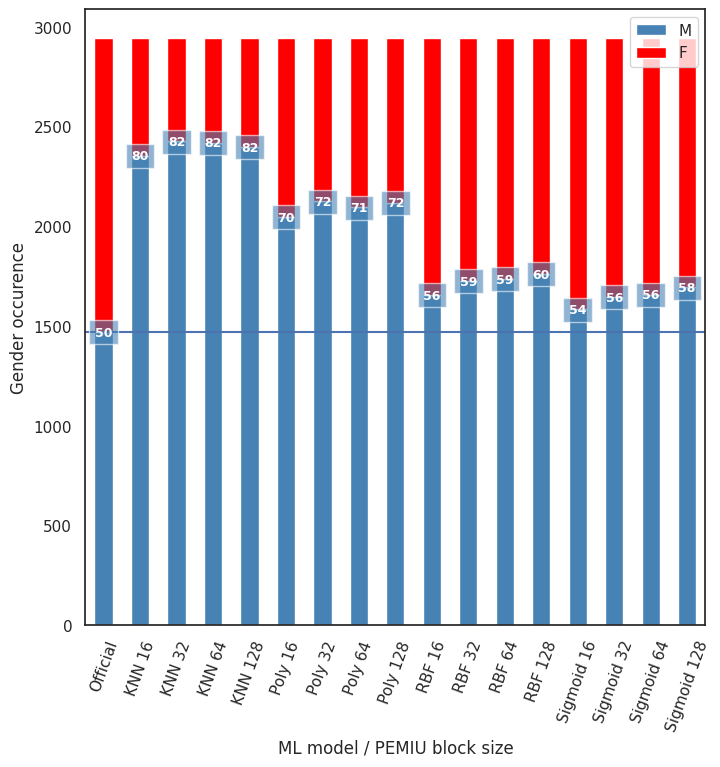

In [42]:
#set seaborn plotting aesthetics
sns.set(style='white')

labels = ['Official',
        'KNN 16', 'KNN 32', 'KNN 64', 'KNN 128',
         'Poly 16', 'Poly 32', 'Poly 64', 'Poly 128',
         'RBF 16', 'RBF 32', 'RBF 64', 'RBF 128',
         'Sigmoid 16', 'Sigmoid 32', 'Sigmoid 64', 'Sigmoid 128',]

#create stacked bar chart
ax = df_gender_count_fromimg.set_index('Model').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU block size', ylabel='Gender occurence')
# ax.set_title("Distribution of predicted gender using different ML algorithms\n" \
#              f"on PEMIU enhanced embeddings using {face_extractor} at varying block sizes")
#ax.set_title(f"{face_extractor}")
ax.axhline(df_gender_count_fromimg.iloc[0][1])

for index, p in enumerate(ax.patches):
    if index < 17:
        percent_male = df_gender_count_fromimg['M'][index]
        percent_total = df_gender_count_fromimg.iloc[1][1] + df_gender_count_fromimg.iloc[1][2]
        percentage = format(round(percent_male / percent_total * 100, 0), '.0f')
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}', (x-0.25, y-20), ha='center', fontweight='bold', fontsize=9, c='white', bbox=dict(facecolor='steelblue', alpha=0.6))
    
plt.savefig(f'{plt_savepath}04_05_gender_predict_ml_gender_distribution.svg', bbox_inches='tight')
plt.show()

### Gender prediction using InsightFace model

### Benchmark for InsightFace gender prediction model

- Confusion matrix for gender prediction using InsightFace
- Test InsightFace gender prediction model on original LFW images and official labels

In [6]:
if_prediction_rate = []

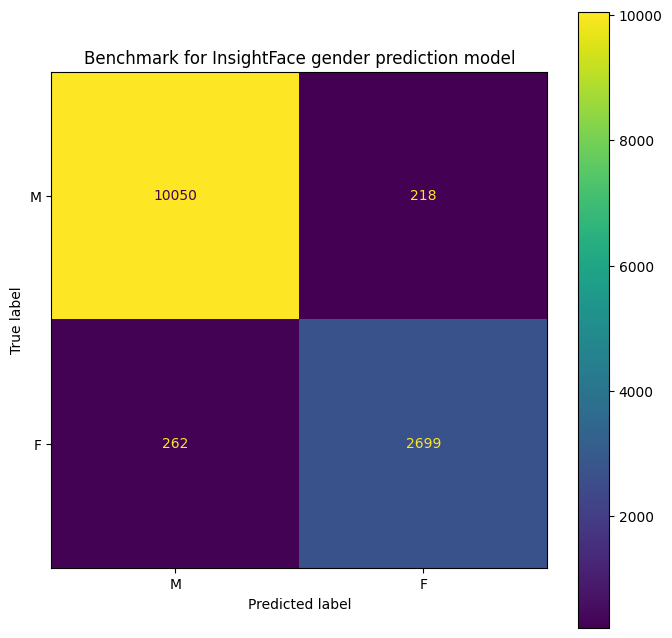

InsightFace false prediction rate: 3.66 %


In [7]:
cm = confusion_matrix(df_pairs_gender['gender_official'], df_pairs_gender['gender_insightface'], labels=["M", "F"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["M", "F"])
disp.plot(values_format = '')

plt.title("Benchmark for InsightFace gender prediction model")

plt.show()

false_prediction_unmodified = []
for index, element in enumerate(df_pairs_gender['gender_official']):
    if not df_pairs_gender['gender_insightface'].iloc[index]:
        break
    if element != df_pairs_gender['gender_insightface'][index]:
        false_prediction_unmodified.append(element)
        
if_prediction_rate.append(round((len(false_prediction_unmodified) / len(df_pairs_gender) * 100), 2))

print(f"InsightFace false prediction rate: {if_prediction_rate[0]} %")

In [8]:
df_insightface_prediction.head()

Unnamed: 0              filename  \
0           0    Aaron_Eckhart_0001   
1           1      Aaron_Guiel_0001   
2           2  Aaron_Patterson_0001   
3           3    Aaron_Peirsol_0001   
4           4    Aaron_Peirsol_0002   

                                        img_original  \
0  ../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...   
1  ../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...   
2  ../data/lfw_align/Aaron_Patterson/Aaron_Patter...   
3  ../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...   
4  ../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...   

                                   img_reconstructed  \
0  ../recreate_icip2022_face_reconstruction/exper...   
1  ../recreate_icip2022_face_reconstruction/exper...   
2  ../recreate_icip2022_face_reconstruction/exper...   
3  ../recreate_icip2022_face_reconstruction/exper...   
4  ../recreate_icip2022_face_reconstruction/exper...   

                                        img_pemiu_16  \
0  ../recreate_icip2022_face_reconstruction/exper...   
1  ../recreate_icip2022_face_reconstruction/exper...   
2  ../recreate_icip2022_face_reconstruction/exper...   
3  ../recreate_icip2022_face_reconstruction/exper...   
4  ../recreate_icip2022_face_reconstruction/exper...   

                                        img_pemiu_32  \
0  ../recreate_icip2022_face_reconstruction/exper...   
1  ../recreate_icip2022_face_reconstruction/exper...   
2  ../recreate_icip2022_face_reconstruction/exper...   
3  ../recreate_icip2022_face_reconstruction/exper...   
4  ../recreate_icip2022_face_reconstruction/exper...   

                                        img_pemiu_64  \
0  ../recreate_icip2022_face_reconstruction/exper...   
1  ../recreate_icip2022_face_reconstruction/exper...   
2  ../recreate_icip2022_face_reconstruction/exper...   
3  ../recreate_icip2022_face_reconstruction/exper...   
4  ../recreate_icip2022_face_reconstruction/exper...   

                                       img_pemiu_128 gender_official  \
0  ../recreate_icip2022_face_reconstruction/exper...               M   
1  ../recreate_icip2022_face_reconstruction/exper...               M   
2  ../recreate_icip2022_face_reconstruction/exper...               M   
3  ../recreate_icip2022_face_reconstruction/exper...               M   
4  ../recreate_icip2022_face_reconstruction/exper...               M   

  gender_insightface_img_original gender_insightface_img_reconstructed  \
0                               M                                    M   
1                               M                                    M   
2                               M                                    M   
3                               M                                    F   
4                               M                                    M   

  gender_insightface_img_pemiu_16 gender_insightface_img_pemiu_32  \
0                               F                               M   
1                               F                               F   
2                               F                               F   
3                               M                               F   
4                               M                               F   

  gender_insightface_img_pemiu_64 gender_insightface_img_pemiu_128  
0                               F                                F  
1                               M                                F  
2                               M                                F  
3                               F                                F  
4                               F                                F

In [9]:
df_insightface_prediction.columns.tolist()

['Unnamed: 0',
 'filename',
 'img_original',
 'img_reconstructed',
 'img_pemiu_16',
 'img_pemiu_32',
 'img_pemiu_64',
 'img_pemiu_128',
 'gender_official',
 'gender_insightface_img_original',
 'gender_insightface_img_reconstructed',
 'gender_insightface_img_pemiu_16',
 'gender_insightface_img_pemiu_32',
 'gender_insightface_img_pemiu_64',
 'gender_insightface_img_pemiu_128']

### InsightFace gender prediction on images synthesized from unprotected templates

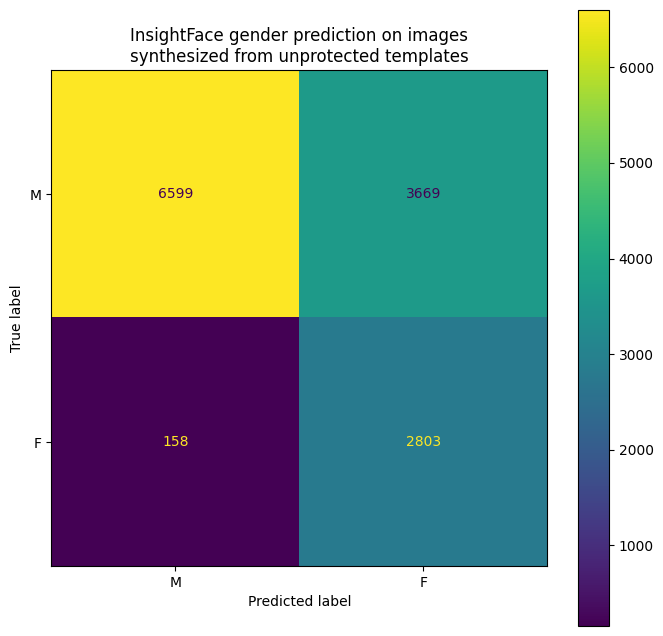

InsightFace false prediction rate: 28.92 %


In [10]:
cm = confusion_matrix(df_insightface_prediction['gender_official'], df_insightface_prediction['gender_insightface_img_reconstructed'], labels=["M", "F"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["M", "F"])
disp.plot(values_format = '')

plt.title("InsightFace gender prediction on images\nsynthesized from unprotected templates")

plt.show()

false_prediction_unmodified = []
for index, element in enumerate(df_insightface_prediction['gender_official']):
    if element != df_insightface_prediction['gender_insightface_img_reconstructed'][index]:
        false_prediction_unmodified.append(element)
        
if_prediction_rate.append(round((len(false_prediction_unmodified) / len(df_pairs_gender) * 100), 2))
        
print(f"InsightFace false prediction rate: {if_prediction_rate[1]} %")

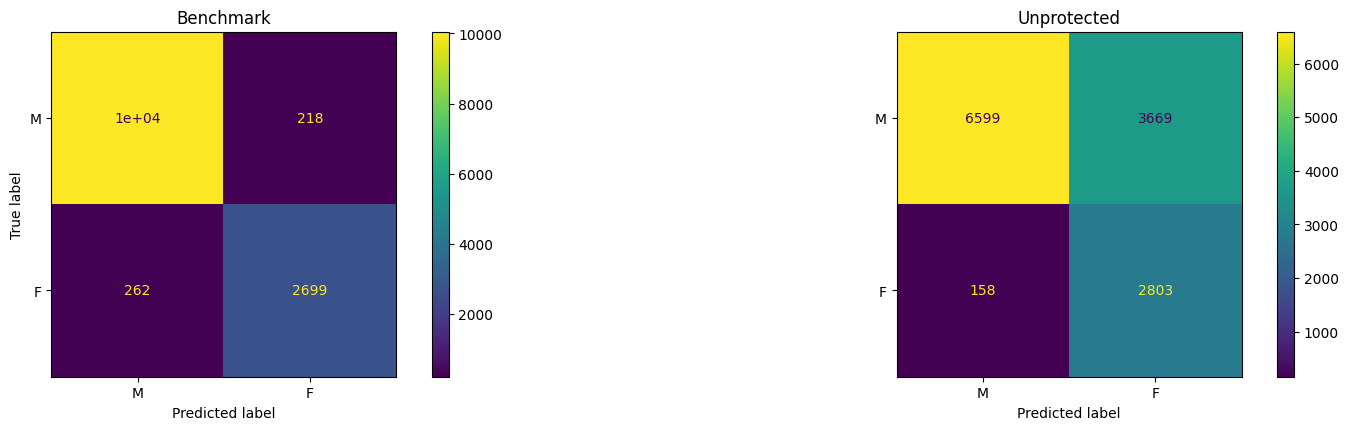

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
fig.subplots_adjust(top=0.8)
# Title
# fig.suptitle("InsightFace gender prediction on original images as benchmark\n" \
#              "and recontructed from unprotected embeddings")
#fig.suptitle(f"{face_extractor}")
for i, (title, ax) in enumerate(zip(["Benchmark", "Unprotected"], fig.get_axes())):
    if i == 0:
        cf_matrix  = confusion_matrix(df_insightface_prediction['gender_official'], df_insightface_prediction[f'gender_insightface_img_original'], labels=["M", "F"])
    else:
        cf_matrix  = confusion_matrix(df_insightface_prediction['gender_official'], df_insightface_prediction[f'gender_insightface_img_reconstructed'], labels=["M", "F"])
    disp = ConfusionMatrixDisplay(cf_matrix,
                              display_labels=["M", "F"])
    disp.plot(ax=axes[i])
    disp.ax_.set_title(f"{title}")
    #disp.im_.colorbar.remove()
    # disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

# plt.title("InsightFace gender prediction on images\nsynthesized from unprotected templates")
#fig.colorbar(disp.im_, ax=axes)
plt.savefig(f'{plt_savepath}04_06_gender_predict_insightface_cm_benchmark_unprotected.svg', bbox_inches='tight')
plt.show()

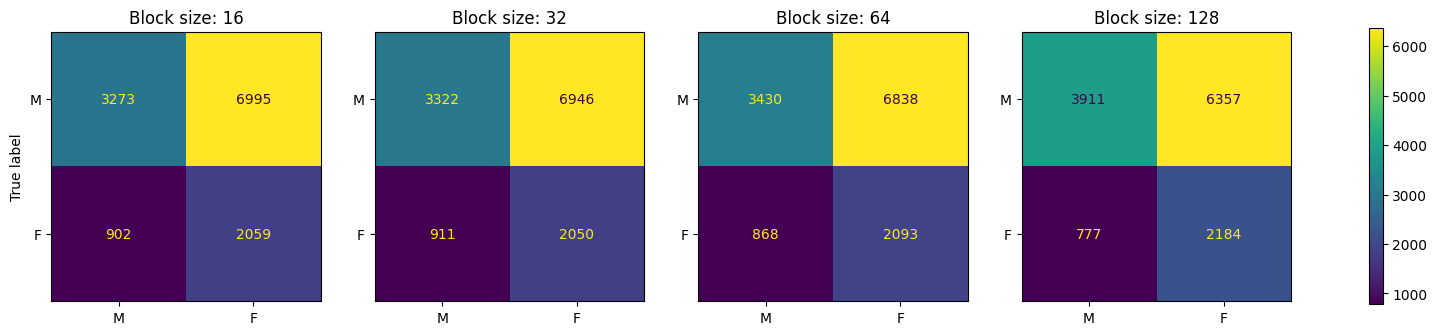

InsightFace false prediction rate: 59.68 %
InsightFace false prediction rate: 59.37 %
InsightFace false prediction rate: 58.23 %
InsightFace false prediction rate: 53.91 %


In [12]:
fig, axes = plt.subplots(1, 4, figsize = (20, 4))
fig.subplots_adjust(top=0.8)
# Title
# fig.suptitle("InsightFace gender prediction on images synthesized from PEMIU protected templates\n" \
#              "at varying block sizes")
#fig.suptitle(f"{face_extractor}")
for i, (blocksize, ax) in enumerate(zip(block_sizes, fig.get_axes())):
    cf_matrix  = confusion_matrix(df_insightface_prediction['gender_official'], df_insightface_prediction[f'gender_insightface_img_pemiu_{blocksize}'], labels=["M", "F"])
    disp = ConfusionMatrixDisplay(cf_matrix,
                              display_labels=["M", "F"])
    disp.plot(ax=axes[i])
    disp.ax_.set_title(f"Block size: {blocksize}")
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

# plt.title("InsightFace gender prediction on images\nsynthesized from unprotected templates")
fig.colorbar(disp.im_, ax=axes)
plt.savefig(f'{plt_savepath}04_07_gender_predict_insightface_cm_pemiu.svg', bbox_inches='tight')
plt.show()

for i, blocksize in enumerate(block_sizes):
    false_prediction_unmodified = []
    for index, element in enumerate(df_insightface_prediction['gender_official']):
        if element != df_insightface_prediction[f'gender_insightface_img_pemiu_{blocksize}'][index]:
            false_prediction_unmodified.append(element)
    if_prediction_rate.append(round((len(false_prediction_unmodified) / len(df_pairs_gender) * 100), 2))
    print(f"InsightFace false prediction rate: {if_prediction_rate[i+2]} %")

In [13]:
if_prediction_rate

[3.66, 28.92, 59.68, 59.37, 58.23, 53.91]

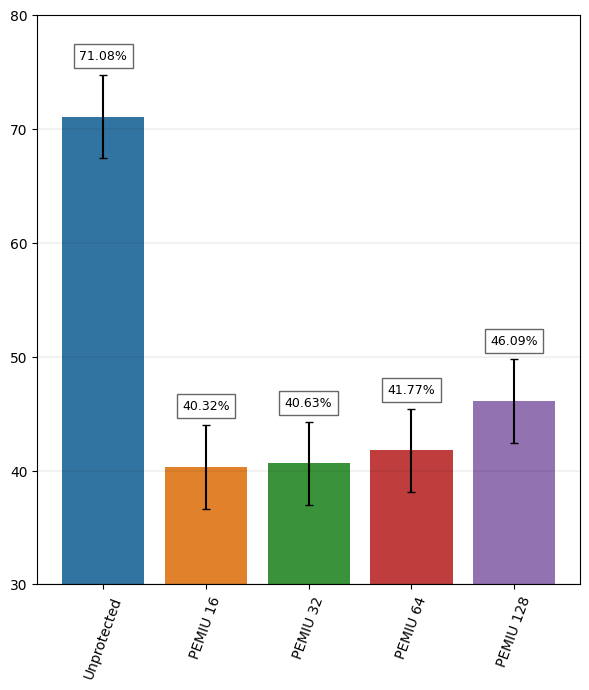

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)

# Title
# fig.suptitle(f"Gender prediction attack with InsightFace on reconstructed images using {face_extractor}:\n" \
#              "Success attack rate for unprotected and PEMIU enhanced at varying block sizes\n")
#fig.suptitle(f"{face_extractor}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
df = pd.DataFrame(if_prediction_rate, ["Benchmark", "Unprotected", "PEMIU 16", "PEMIU 32", "PEMIU 64", "PEMIU 128"])
df = df.T

df = df.apply(lambda x: (x-100)*-1)

sns.barplot(data=df.iloc[:, 1:], 
            ax=ax)
ax.set_xticklabels(df.columns.tolist()[1:], rotation=70)

for index, p in enumerate(ax.patches):
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(f'{df.iloc[0].tolist()[index+1]}%', (x-0.4, y+5), ha='center', 
                fontweight='normal', fontsize=9, c='black', bbox=dict(facecolor='white', alpha=0.6)) 
    ax.errorbar(x=x-0.4, y=y, yerr=((df.iloc[0].tolist()[0] - 100) * -1), fmt="none", c="k", capsize=3)

plt.ylim([30, 80])
    
plt.savefig(f'{plt_savepath}04_08_gender_predict_insightface_success_rate.svg', bbox_inches='tight')
plt.show()

### Distribution of predicted gender with InsightFace

In [52]:
# Dataset that only contains (1) one sample per image, (2) balanced genders
# was also used for the distribution experiment performed with ML
df_gender_pred_from_predicted_labels.head()

filename  img_original_quality  \
0     Aaron_Eckhart_0001              0.785188   
77    Adelina_Avila_0001              0.846964   
1       Aaron_Guiel_0001              0.764814   
88     Adriana_Lima_0001              0.736330   
2   Aaron_Patterson_0001              0.737193   

                                      pemiu16_fromimg  \
0   experiments/experiment_7_model1_pemiu_block_si...   
77  experiments/experiment_7_model1_pemiu_block_si...   
1   experiments/experiment_7_model1_pemiu_block_si...   
88  experiments/experiment_7_model1_pemiu_block_si...   
2   experiments/experiment_7_model1_pemiu_block_si...   

                                      pemiu32_fromimg  \
0   experiments/experiment_7_model1_pemiu_block_si...   
77  experiments/experiment_7_model1_pemiu_block_si...   
1   experiments/experiment_7_model1_pemiu_block_si...   
88  experiments/experiment_7_model1_pemiu_block_si...   
2   experiments/experiment_7_model1_pemiu_block_si...   

                                      pemiu64_fromimg  \
0   experiments/experiment_7_model1_pemiu_block_si...   
77  experiments/experiment_7_model1_pemiu_block_si...   
1   experiments/experiment_7_model1_pemiu_block_si...   
88  experiments/experiment_7_model1_pemiu_block_si...   
2   experiments/experiment_7_model1_pemiu_block_si...   

                                     pemiu128_fromimg  \
0   experiments/experiment_7_model1_pemiu_block_si...   
77  experiments/experiment_7_model1_pemiu_block_si...   
1   experiments/experiment_7_model1_pemiu_block_si...   
88  experiments/experiment_7_model1_pemiu_block_si...   
2   experiments/experiment_7_model1_pemiu_block_si...   

                                       pemiu0_fromimg  \
0   experiments/experiment_7_model1_pemiu_block_si...   
77  experiments/experiment_7_model1_pemiu_block_si...   
1   experiments/experiment_7_model1_pemiu_block_si...   
88  experiments/experiment_7_model1_pemiu_block_si...   
2   experiments/experiment_7_model1_pemiu_block_si...   

                                              pemiu16  \
0   ../data/features_cleaner_pemiu16/Aaron_Eckhart...   
77  ../data/features_cleaner_pemiu16/Adelina_Avila...   
1   ../data/features_cleaner_pemiu16/Aaron_Guiel_0...   
88  ../data/features_cleaner_pemiu16/Adriana_Lima_...   
2   ../data/features_cleaner_pemiu16/Aaron_Patters...   

                                              pemiu32  \
0   ../data/features_cleaner_pemiu32/Aaron_Eckhart...   
77  ../data/features_cleaner_pemiu32/Adelina_Avila...   
1   ../data/features_cleaner_pemiu32/Aaron_Guiel_0...   
88  ../data/features_cleaner_pemiu32/Adriana_Lima_...   
2   ../data/features_cleaner_pemiu32/Aaron_Patters...   

                                              pemiu64  ...  \
0   ../data/features_cleaner_pemiu64/Aaron_Eckhart...  ...   
77  ../data/features_cleaner_pemiu64/Adelina_Avila...  ...   
1   ../data/features_cleaner_pemiu64/Aaron_Guiel_0...  ...   
88  ../data/features_cleaner_pemiu64/Adriana_Lima_...  ...   
2   ../data/features_cleaner_pemiu64/Aaron_Patters...  ...   

   pred_fromembedding_64_svm_poly pred_fromembedding_128_svm_poly  \
0                               M                               M   
77                              M                               M   
1                               M                               M   
88                              M                               M   
2                               M                               M   

   pred_fromembedding_16_svm_rbf  pred_fromembedding_32_svm_rbf  \
0                              M                              M   
77                             F                              M   
1                              F                              F   
88                             F                              F   
2                              M                              F   

    pred_fromembedding_64_svm_rbf  pred_fromembedding_128_svm_rbf  \
0                               M                     

In [53]:
# Dataset contains all insightface predictions
df_insightface_prediction.shape

(13229, 15)

In [127]:
df_insightface_prediction

Unnamed: 0                 filename  \
0               0       Aaron_Eckhart_0001   
1               1         Aaron_Guiel_0001   
2               2     Aaron_Patterson_0001   
3               3       Aaron_Peirsol_0001   
4               4       Aaron_Peirsol_0002   
...           ...                      ...   
13224       13224      Zorica_Radovic_0001   
13225       13225      Zulfiqar_Ahmed_0001   
13226       13226        Zumrati_Juma_0001   
13227       13227     Zurab_Tsereteli_0001   
13228       13228  Zydrunas_Ilgauskas_0001   

                                            img_original  \
0      ../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...   
1      ../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...   
2      ../data/lfw_align/Aaron_Patterson/Aaron_Patter...   
3      ../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...   
4      ../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...   
...                                                  ...   
13224  ../data/lfw_align/Zorica_Radovic/Zorica_Radovi...   
13225  ../data/lfw_align/Zulfiqar_Ahmed/Zulfiqar_Ahme...   
13226  ../data/lfw_align/Zumrati_Juma/Zumrati_Juma_00...   
13227  ../data/lfw_align/Zurab_Tsereteli/Zurab_Tseret...   
13228  ../data/lfw_align/Zydrunas_Ilgauskas/Zydrunas_...   

                                       img_reconstructed  \
0      ../recreate_icip2022_face_reconstruction/exper...   
1      ../recreate_icip2022_face_reconstruction/exper...   
2      ../recreate_icip2022_face_reconstruction/exper...   
3      ../recreate_icip2022_face_reconstruction/exper...   
4      ../recreate_icip2022_face_reconstruction/exper...   
...                                                  ...   
13224  ../recreate_icip2022_face_reconstruction/exper...   
13225  ../recreate_icip2022_face_reconstruction/exper...   
13226  ../recreate_icip2022_face_reconstruction/exper...   
13227  ../recreate_icip2022_face_reconstruction/exper...   
13228  ../recreate_icip2022_face_reconstruction/exper...   

                                            img_pemiu_16  \
0      ../recreate_icip2022_face_reconstruction/exper...   
1      ../recreate_icip2022_face_reconstruction/exper...   
2      ../recreate_icip2022_face_reconstruction/exper...   
3      ../recreate_icip2022_face_reconstruction/exper...   
4      ../recreate_icip2022_face_reconstruction/exper...   
...                                                  ...   
13224  ../recreate_icip2022_face_reconstruction/exper...   
13225  ../recreate_icip2022_face_reconstruction/exper...   
13226  ../recreate_icip2022_face_reconstruction/exper...   
13227  ../recreate_icip2022_face_reconstruction/exper...   
13228  ../recreate_icip2022_face_reconstruction/exper...   

                                            img_pemiu_32  \
0      ../recreate_icip2022_face_reconstruction/exper...   
1      ../recreate_icip2022_face_reconstruction/exper...   
2      ../recreate_icip2022_face_reconstruction/exper...   
3      ../recreate_icip2022_face_reconstruction/exper...   
4      ../recreate_icip2022_face_reconstruction/exper...   
...                                                  ...   
13224  ../recreate_icip2022_face_reconstruction/exper...   
13225  ../recreate_icip2022_face_reconstruction/exper...   
13226  ../recreate_icip2022_face_reconstruction/exper...   
13227  ../recreate_icip2022_face_reconstruction/exper...   
13228  ../recreate_icip2022_face_reconstruction/exper...   

                                            img_pemiu_64  \
0      ../recreate_icip2022_face_reconstruction/exper...   
1      ../recreate_icip2022_face_reconstruction/exper...   
2      ../recreate_icip2022_face_reconstruction/exper...   
3      ../recreate_icip2022_face_reconstruction/exper...   
4      ../recreate_icip2022_face_reconstruction/exper...   
...                                                  ...   
13224  ../recreate_icip2022_face_reconstruction/exper...   
13225  ../recreate_icip2022_face_reconstruction/exper...   
13226  ../recreate_icip2022_fa

In [137]:
df_insightface_prediction.columns

Index(['Unnamed: 0', 'filename', 'img_original', 'img_reconstructed',
       'img_pemiu_16', 'img_pemiu_32', 'img_pemiu_64', 'img_pemiu_128',
       'gender_official', 'gender_insightface_img_original',
       'gender_insightface_img_reconstructed',
       'gender_insightface_img_pemiu_16', 'gender_insightface_img_pemiu_32',
       'gender_insightface_img_pemiu_64', 'gender_insightface_img_pemiu_128'],
      dtype='object')

In [140]:
df_insightface_prediction_reduced = df_gender_pred_from_predicted_labels.merge(df_insightface_prediction, on=['filename'], how='left')
df_insightface_prediction_reduced[['gender_official_x', 'gender_official_y']]

gender_official_x gender_official_y
0                    M                 M
1                    F                 F
2                    M                 M
3                    F                 F
4                    M                 M
...                ...               ...
2937                 F                 F
2938                 M                 M
2939                 F                 F
2940                 M                 M
2941                 F                 F

[2942 rows x 2 columns]

In [156]:
# InsightFace prediction rate for LFW balanced
length_frame = len(df_insightface_prediction_reduced)
correct_if = []
for blocksize in block_sizes:
    correct_if.append(len(df_insightface_prediction_reduced[df_insightface_prediction_reduced[f'gender_insightface_img_pemiu_{blocksize}'] == df_insightface_prediction_reduced['gender_official_x']]))

#length_frame
[round(x/length_frame, 4) * 100 for x in correct_if]

[51.05, 52.75, 53.059999999999995, 56.38999999999999]

In [55]:
df_insightface_gender_pred_distribution = pd.DataFrame()

for index, blocksize in enumerate(block_sizes):
    gender_flow = pd.DataFrame()
    df = df_insightface_prediction_reduced[df_insightface_prediction_reduced[f'gender_insightface_img_pemiu_{blocksize}'].notnull().values]
    gender_flow = df[['gender_official_x', f'gender_insightface_img_pemiu_{blocksize}']]
    df_insightface_gender_pred_distribution[f'InsightFace {blocksize}'] = gender_flow[f'gender_insightface_img_pemiu_{blocksize}'].value_counts()
    
df_insightface_gender_pred_distribution['gender_official'] = df['gender_official_x'].value_counts()

# Reorder dataframe
df_insightface_gender_pred_distribution = df_insightface_gender_pred_distribution.T
df_insightface_gender_pred_distribution = df_insightface_gender_pred_distribution.iloc[[4, 0, 1, 2, 3],[1,0]]
df_insightface_gender_pred_distribution.index.name = 'Model'
df_insightface_gender_pred_distribution.reset_index(inplace=True)
df_insightface_gender_pred_distribution

Model     M     F
0  gender_official  1471  1471
1   InsightFace 16   897  2045
2   InsightFace 32   937  2005
3   InsightFace 64   906  2036
4  InsightFace 128   936  2006

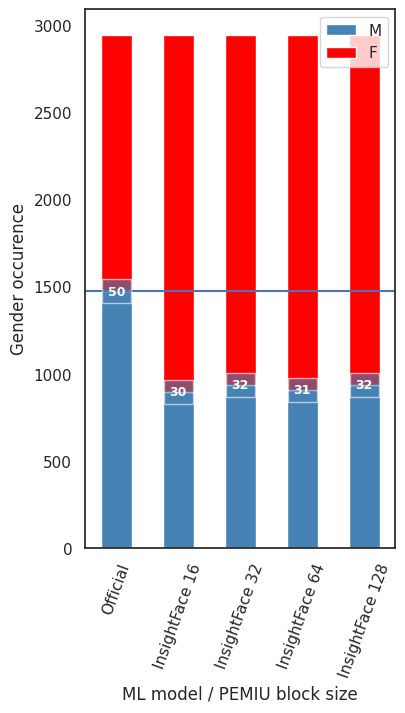

In [56]:
#set seaborn plotting aesthetics
sns.set(style='white')

labels = ['Official',
        'InsightFace 16', 'InsightFace 32', 'InsightFace 64', 'InsightFace 128']
fig, ax = plt.subplots(1, 1, figsize = (4, 7))

#create stacked bar chart
df_insightface_gender_pred_distribution.set_index('Model').plot(kind='bar', stacked=True, color=['steelblue', 'red'], ax=ax)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU block size', ylabel='Gender occurence')
# ax.set_title(f"Distribution of predicted gender using InsightFace\n" \
#              f"on PEMIU enhanced embeddings with {face_extractor} at varying block sizes")
#ax.set_title(f"{face_extractor}")
ax.axhline(df_insightface_gender_pred_distribution.iloc[0][1])

for index, p in enumerate(ax.patches):
    if index < 5:
        percent_male = df_insightface_gender_pred_distribution['M'][index]
        percent_total = df_insightface_gender_pred_distribution.iloc[index][1] + df_insightface_gender_pred_distribution.iloc[index][2]
        percentage = format(round(percent_male / percent_total * 100, 0), '.0f')
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}', (x-0.25, y-20), ha='center', fontweight='bold', fontsize=9, c='white', bbox=dict(facecolor='steelblue', alpha=0.6))
    
plt.savefig(f'{plt_savepath}04_09_gender_predict_insightface_gender_distribution.svg', bbox_inches='tight')
plt.show()

### InsightFace gender prediction on images synthesized from unprotected templates, which pass the system threshold TH100 and TH1000

In [157]:
labels = ['InsightFace 16', 'InsightFace 32', 'InsightFace 64', 'InsightFace 128']
df_gender_pred_insightface_blocksizes = pd.DataFrame(columns=['blocksize', 'Successful predictions', 'Possible predictions'])

# Filter dataframe to only contain rows that were predicted at blocksize
for index, blocksize in enumerate(block_sizes):
    df = df_insightface_prediction_th100[df_insightface_prediction_th100[f'gender_insightface_{blocksize}'].notnull().values]
    total_number_of_predictions = len(df)
    correct_predictions = len(df[df['gender_official'] == df[f'gender_insightface_{blocksize}']])
    df_gender_pred_insightface_blocksizes.loc[index] = [blocksize, correct_predictions, total_number_of_predictions]
df_gender_pred_insightface_blocksizes

blocksize  Successful predictions  Possible predictions
0        16                     387                   757
1        32                     352                   734
2        64                     740                  1540
3       128                    1413                  2655

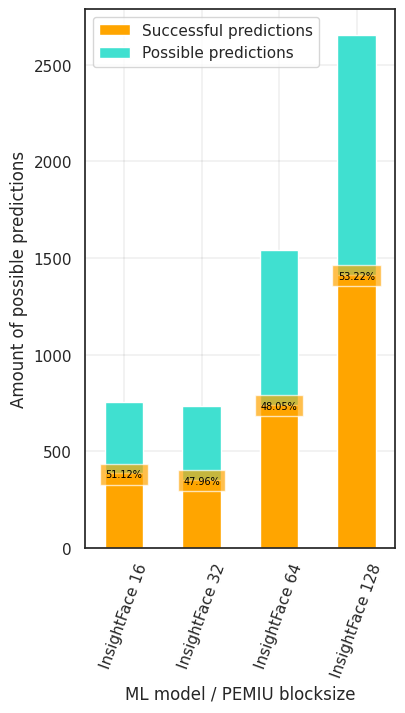

In [158]:
# set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
fig, ax = plt.subplots(1, 1, figsize = (4, 7))
df_gender_pred_insightface_blocksizes.iloc[:,[0,1]].set_index('blocksize').plot(kind='bar', color=['orange'], ax=ax, zorder=2)
df_gender_pred_insightface_blocksizes.iloc[:,[0,2]].set_index('blocksize').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Amount of possible predictions')
# ax.set_title(f"Gender prediction attack with InsightFace on synthesized images using {face_extractor}.\n" \
#              "Considering only identities, where the reconstrcuted image passes the FMR100 threshold")

ax.grid(visible=True, which='major', color='black', linewidth=0.075)
#ax.set_title(f"{face_extractor}")
for index, p in enumerate(ax.patches):
    if index < 4:
        percentage = round(df_gender_pred_insightface_blocksizes['Successful predictions'][index] / df_gender_pred_insightface_blocksizes['Possible predictions'][index] * 100, 2)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}%', (x-0.25, y-20), ha='center', fontweight='normal', fontsize=7, c='black', bbox=dict(facecolor='orange', alpha=0.7))
        # ax.annotate(f'{percentage}%', (x-0.1, y+50), ha='center', fontsize=9)
        
plt.savefig(f'{plt_savepath}04_10_gender_predict_insightface_success_rate_th100.svg', bbox_inches='tight')
plt.show()

In [160]:
labels = ['InsightFace 16', 'InsightFace 32', 'InsightFace 64', 'InsightFace 128']
df_gender_pred_insightface_blocksizes = pd.DataFrame(columns=['blocksize', 'Successful predictions', 'Possible predictions'])

# Filter dataframe to only contain rows that were predicted at blocksize
for index, blocksize in enumerate(block_sizes):
    df = df_insightface_prediction_th1000[df_insightface_prediction_th1000[f'gender_insightface_{blocksize}'].notnull().values]
    total_number_of_predictions = len(df)
    correct_predictions = len(df[df['gender_official'] == df[f'gender_insightface_{blocksize}']])
    df_gender_pred_insightface_blocksizes.loc[index] = [blocksize, correct_predictions, total_number_of_predictions]
df_gender_pred_insightface_blocksizes

blocksize  Successful predictions  Possible predictions
0        16                      53                    85
1        32                      77                   143
2        64                     314                   557
3       128                     943                  1646

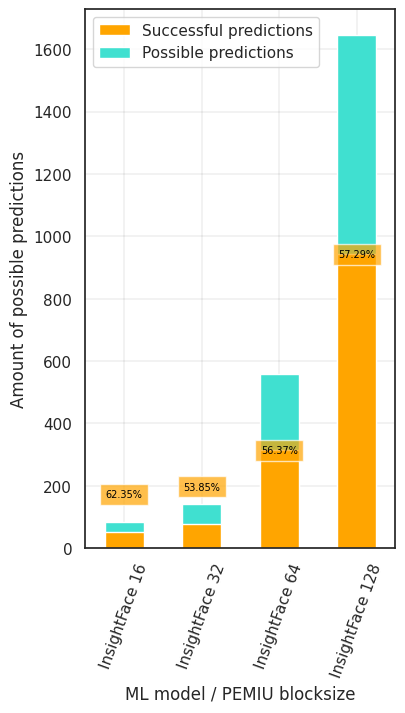

In [161]:
# set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
fig, ax = plt.subplots(1, 1, figsize = (4, 7))
df_gender_pred_insightface_blocksizes.iloc[:,[0,1]].set_index('blocksize').plot(kind='bar', color=['orange'], ax=ax, zorder=2)
df_gender_pred_insightface_blocksizes.iloc[:,[0,2]].set_index('blocksize').plot(kind='bar', color=['turquoise'], ax=ax, zorder=1)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU blocksize', ylabel='Amount of possible predictions')
# ax.set_title(f"Gender prediction attack with InsightFace on synthesized images with {face_extractor}\n" \
#              "Considering only identities, where the reconstrcuted image passes the FMR1000 threshold")
#ax.set_title(f"{face_extractor}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)

for index, p in enumerate(ax.patches):
    if index < 4:
        percentage = round(df_gender_pred_insightface_blocksizes['Successful predictions'][index] / df_gender_pred_insightface_blocksizes['Possible predictions'][index] * 100, 2)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        # Form an offset to place the label above columns when columns are very small
        offset = 0
        if y < 115:
            offset = +110
        else:
            offset = -10
        ax.annotate(f'{percentage}%', (x-0.25, y+offset), ha='center', fontweight='normal', fontsize=7, c='black', bbox=dict(facecolor='orange', alpha=0.7))
        
plt.savefig(f'{plt_savepath}04_11_gender_predict_insightface_success_rate_th1000.svg', bbox_inches='tight')
plt.show()

---

# End of evaluation

In [91]:
##################################################################
# Redundant code
##################################################################

### Sankey flow diagrams of gender prediction at TH100

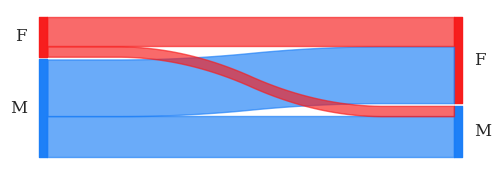

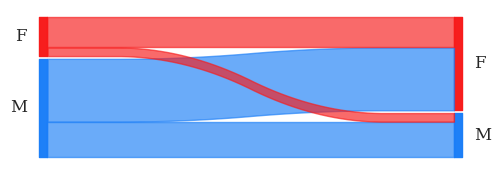

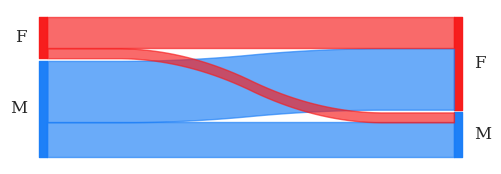

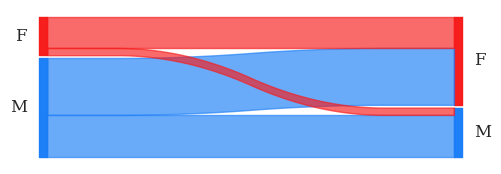

In [62]:
for index, blocksize in enumerate(block_sizes):
    fig, ax = plt.subplots(1, 1, figsize = (6, 2))

    colorDict = {
        'M':'#1b7ef7',
        'F':'#f71b1b',
    }

    gender_flow = pd.DataFrame()

    df = df_insightface_prediction_th100[df_insightface_prediction_th100[f'gender_insightface_{blocksize}'].notnull().values]
    gender_flow = df[['gender_official', f'gender_insightface_{blocksize}']]

    fig = sankey(
        gender_flow['gender_official'], gender_flow[f'gender_insightface_{blocksize}'], aspect=10, colorDict=colorDict,
        leftLabels=['M','F'],
        rightLabels=['M','F'],
        fontsize=12
    )

    plt.show()

In [64]:
df_insightface_gender_pred_distribution = pd.DataFrame()

for index, blocksize in enumerate(block_sizes):
    gender_flow = pd.DataFrame()
    df = df_insightface_prediction_th100[df_insightface_prediction_th100[f'gender_insightface_{blocksize}'].notnull().values]
    gender_flow = df[['gender_official', f'gender_insightface_{blocksize}']]
    df_insightface_gender_pred_distribution[f'InsightFace {blocksize}'] = gender_flow[f'gender_insightface_{blocksize}'].value_counts()
    
df_insightface_gender_pred_distribution['gender_official'] = df['gender_official'].value_counts()

# Reorder dataframe
df_insightface_gender_pred_distribution = df_insightface_gender_pred_distribution.T
df_insightface_gender_pred_distribution = df_insightface_gender_pred_distribution.iloc[[4, 0, 1, 2, 3],[1,0]]
df_insightface_gender_pred_distribution.index.name = 'Model'
df_insightface_gender_pred_distribution.reset_index(inplace=True)
df_insightface_gender_pred_distribution

Model     M     F
0  gender_official  1916   739
1   InsightFace 16   282   475
2   InsightFace 32   235   499
3   InsightFace 64   500  1040
4  InsightFace 128   956  1699

In [65]:
df_insightface_gender_pred_distribution.iloc[1][1] + df_insightface_gender_pred_distribution.iloc[1][2]

757

### Distribution of predicted gender with InsightFace at TH100

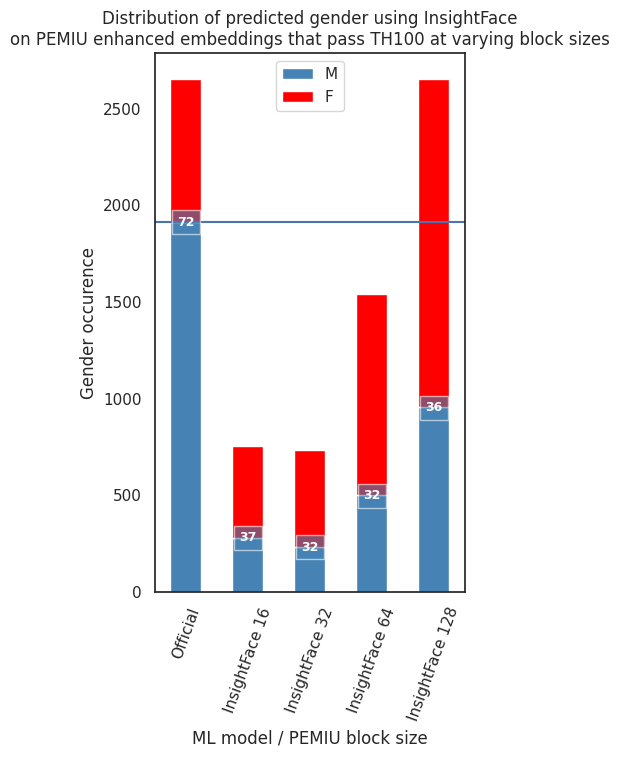

In [66]:
#set seaborn plotting aesthetics
sns.set(style='white')

labels = ['Official',
        'InsightFace 16', 'InsightFace 32', 'InsightFace 64', 'InsightFace 128']
fig, ax = plt.subplots(1, 1, figsize = (4, 7))

#create stacked bar chart
df_insightface_gender_pred_distribution.set_index('Model').plot(kind='bar', stacked=True, color=['steelblue', 'red'], ax=ax)
ax.set_xticklabels(labels, rotation=70)
ax.set(xlabel='ML model / PEMIU block size', ylabel='Gender occurence')
ax.set_title("Distribution of predicted gender using InsightFace\n" \
             "on PEMIU enhanced embeddings that pass TH100 at varying block sizes")

ax.axhline(df_insightface_gender_pred_distribution.iloc[0][1])

for index, p in enumerate(ax.patches):
    if index < 5:
        percent_male = df_insightface_gender_pred_distribution['M'][index]
        percent_total = df_insightface_gender_pred_distribution.iloc[index][1] + df_insightface_gender_pred_distribution.iloc[index][2]
        percentage = format(round(percent_male / percent_total * 100, 0), '.0f')
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(f'{percentage}', (x-0.25, y-20), ha='center', fontweight='bold', fontsize=9, c='white', bbox=dict(facecolor='steelblue', alpha=0.6))
    
plt.show()